In [11]:
# 2D CNN
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

# 2D CNN 모델 정의
class Simple2DCNN(nn.Module):
    def __init__(self):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 160 * 160, 512)  # 640x640 크기에 맞게 조정
        self.fc2 = nn.Linear(512, 2)  # 예시: 클래스가 2개 (변화 감지, 비변화)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 64 * 160 * 160)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def extract_objects(results, confidence_threshold):
    objects = []
    for r in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = r
        if score > confidence_threshold:
            objects.append({
                'bbox': [int(x1), int(y1), int(x2), int(y2)],
                'score': score,
                'class_id': int(class_id)
            })
    return objects

def compare_objects(objects1, objects2, iou_threshold):
    added = []
    removed = []
    
    matched1 = set()
    matched2 = set()
    
    for i, obj1 in enumerate(objects1):
        for j, obj2 in enumerate(objects2):
            if i in matched1 or j in matched2:
                continue
            
            iou = calculate_iou(obj1['bbox'], obj2['bbox'])
            if iou > iou_threshold:
                matched1.add(i)
                matched2.add(j)
                break
        
        if i not in matched1:
            removed.append(obj1)
    
    for j, obj2 in enumerate(objects2):
        if j not in matched2:
            added.append(obj2)
    
    return added, removed

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    iou = intersection / float(area1 + area2 - intersection)
    return iou
    pass    

def visualize_changes(image1, image2, added, removed):
    result_image = np.hstack((image1, image2))
    height, width = image1.shape[:2]
    
    for obj in added:
        x1, y1, x2, y2 = obj['bbox']
        cv2.rectangle(result_image, (x1 + width, y1), (x2 + width, y2), (0, 255, 0), 2)
        cv2.putText(result_image, 'Added', (x1 + width, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    for obj in removed:
        x1, y1, x2, y2 = obj['bbox']
        cv2.rectangle(result_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(result_image, 'Removed', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    
    cv2.imshow('Changes Detected', result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    pass

def analyze_results(objects1, objects2, added, removed):
    print(f"Image 1: {len(objects1)} objects detected")
    print(f"Image 2: {len(objects2)} objects detected")
    print(f"Added objects: {len(added)}")
    print(f"Removed objects: {len(removed)}")
    
    class_counts1 = {}
    class_counts2 = {}
    
    for obj in objects1:
        class_counts1[obj['class_id']] = class_counts1.get(obj['class_id'], 0) + 1
    
    for obj in objects2:
        class_counts2[obj['class_id']] = class_counts2.get(obj['class_id'], 0) + 1
    
    print("\nClass distribution in Image 1:")
    for class_id, count in class_counts1.items():
        print(f"Class {class_id}: {count}")
    
    print("\nClass distribution in Image 2:")
    for class_id, count in class_counts2.items():
        print(f"Class {class_id}: {count}")


# 변화 감지 함수
def detect_changes_2d(image1_path, image2_path, model_path, cnn_model, confidence_threshold=0.5, iou_threshold=0.5):
    # YOLO 모델 로드
    model = YOLO(model_path)

    # 이미지 로드
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # YOLO를 사용하여 객체 탐지
    results1 = model(image1)[0]
    results2 = model(image2)[0]

    # 객체 추출
    objects1 = extract_objects(results1, confidence_threshold)
    objects2 = extract_objects(results2, confidence_threshold)

    # 객체 비교 (기존 방식 유지)
    added, removed = compare_objects(objects1, objects2, iou_threshold)

    # 이미지를 2D CNN에 입력
    image1_2d = prepare_image_for_2d_cnn(image1)
    image2_2d = prepare_image_for_2d_cnn(image2)

    # 2D CNN을 통한 특징 추출 및 변화 감지
    features1 = cnn_model(image1_2d)
    features2 = cnn_model(image2_2d)
    
    difference = compute_difference_2d(features1, features2)

    # 결과 시각화
    visualize_changes(image1, image2, added, removed)

    # 결과 분석
    analyze_results(objects1, objects2, added, removed)

# 2D CNN에 입력할 이미지를 준비하는 함수
def prepare_image_for_2d_cnn(image):
    # 이미지를 2D CNN에 입력할 수 있도록 변환
    image = cv2.resize(image, (640, 640))
    image_2d = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
    return torch.Tensor(image_2d).unsqueeze(0)  # (B, C, H, W)

# 2D CNN을 통한 특징 비교 함수
def compute_difference_2d(features1, features2):
    # 간단한 유클리드 거리 계산
    return torch.norm(features1 - features2, p=2).item()

# 나머지 기존 함수들 유지 (extract_objects, compare_objects, calculate_iou, visualize_changes, analyze_results)

# CNN 모델 초기화
cnn_model = Simple2DCNN()

# 사용 예시
image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'
image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'
model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'

detect_changes_2d(image1_path, image2_path, model_path, cnn_model)



0: 640x640 4 crossarms, 1 polo, 15 wires, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 crossarms, 1 polo, 19 wires, 15.0ms
Speed: 3.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Image 1: 20 objects detected
Image 2: 24 objects detected
Added objects: 4
Removed objects: 0

Class distribution in Image 1:
Class 2: 15
Class 0: 4
Class 1: 1

Class distribution in Image 2:
Class 2: 19
Class 0: 4
Class 1: 1


In [10]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Simple2DCNN(nn.Module):
    def __init__(self):
        super(Simple2DCNN, self).__init__()
        # 더 깊은 CNN 구조로 변경
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 80 * 80, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(torch.relu(self.batch_norm3(self.conv3(x))))
        x = x.view(-1, 256 * 80 * 80)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

def extract_objects(results, confidence_threshold):
    objects = []
    # 신뢰도 점수에 따른 정렬 추가
    boxes = sorted(results.boxes.data.tolist(), key=lambda x: x[4], reverse=True)
    
    for r in boxes:
        x1, y1, x2, y2, score, class_id = r
        if score > confidence_threshold:
            # 바운딩 박스 정규화 추가
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            w, h = x2 - x1, y2 - y1
            if w > 0 and h > 0:  # 유효한 바운딩 박스만 추가
                objects.append({
                    'bbox': [x1, y1, x2, y2],
                    'score': score,
                    'class_id': int(class_id),
                    'area': w * h  # 면적 정보 추가
                })
    return objects

def compare_objects(objects1, objects2, iou_threshold):
    added = []
    removed = []
    matched1 = set()
    matched2 = set()
    
    # 면적 기반 정렬 추가
    objects1 = sorted(objects1, key=lambda x: x['area'], reverse=True)
    objects2 = sorted(objects2, key=lambda x: x['area'], reverse=True)
    
    for i, obj1 in enumerate(objects1):
        best_iou = iou_threshold
        best_match = -1
        
        for j, obj2 in enumerate(objects2):
            if j in matched2:
                continue
                
            iou = calculate_iou(obj1['bbox'], obj2['bbox'])
            # 클래스 ID가 같은 경우에만 매칭
            if iou > best_iou and obj1['class_id'] == obj2['class_id']:
                best_iou = iou
                best_match = j
        
        if best_match >= 0:
            matched1.add(i)
            matched2.add(best_match)
        else:
            removed.append(obj1)
    
    for j, obj2 in enumerate(objects2):
        if j not in matched2:
            added.append(obj2)
    
    return added, removed

def detect_changes_2d(image1_path, image2_path, model_path, cnn_model, 
                     confidence_threshold=0.45,  # 신뢰도 임계값 조정
                     iou_threshold=0.4):        # IOU 임계값 조정
    # YOLO 모델 로드 및 설정
    model = YOLO(model_path)
    model.conf = confidence_threshold  # 모델 신뢰도 임계값 설정
    model.iou = iou_threshold         # 모델 IOU 임계값 설정
    
    # 이미지 로드 및 전처리
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # 이미지 크기 정규화
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    # YOLO 예측
    results1 = model(image1, verbose=False)[0]  # verbose=False로 불필요한 출력 제거
    results2 = model(image2, verbose=False)[0]
    
    # 객체 추출 및 비교
    objects1 = extract_objects(results1, confidence_threshold)
    objects2 = extract_objects(results2, confidence_threshold)
    
    # 변화 감지
    added, removed = compare_objects(objects1, objects2, iou_threshold)
    
    # CNN 특징 추출
    with torch.no_grad():  # 추론 모드로 변경
        image1_2d = prepare_image_for_2d_cnn(image1)
        image2_2d = prepare_image_for_2d_cnn(image2)
        features1 = cnn_model(image1_2d)
        features2 = cnn_model(image2_2d)
    
    # 결과 시각화 및 분석
    visualize_changes(image1, image2, added, removed)
    analyze_results(objects1, objects2, added, removed)
    
    return added, removed

def prepare_image_for_2d_cnn(image):
    # 이미지 정규화 추가
    image = image.astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    image = torch.Tensor(image).unsqueeze(0)
    return image

# 사용 예시
if __name__ == "__main__":
    image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'
    image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'
    model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
    
    # CNN 모델 초기화 및 평가 모드로 설정
    cnn_model = Simple2DCNN()
    cnn_model.eval()
    
    # 변화 감지 실행
    detect_changes_2d(image1_path, image2_path, model_path, cnn_model)

NameError: name 'visualize_changes' is not defined

In [9]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Simple2DCNN(nn.Module):
    def __init__(self, input_channels=3):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 160 * 160, 512)
        self.fc2 = nn.Linear(512, 2)  # 변화 있음/없음 분류

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_norm2(self.conv2(x))))
        x = x.view(-1, 128 * 160 * 160)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def create_detection_map(image_shape, detections, confidence_threshold=0.25):
    """YOLO 검출 결과를 히트맵으로 변환"""
    detection_map = np.zeros(image_shape[:2], dtype=np.float32)
    
    for det in detections.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls = det
        if conf > confidence_threshold:
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            detection_map[y1:y2, x1:x2] = conf
    
    return detection_map

def detect_changes(image1_path, image2_path, yolo_model_path, cnn_model=None):
    # YOLO 모델 로드
    yolo = YOLO(yolo_model_path)
    
    # 이미지 로드 및 크기 조정
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    # YOLO로 객체 검출
    results1 = yolo(image1)[0]
    results2 = yolo(image2)[0]
    
    # 검출 결과를 히트맵으로 변환
    detection_map1 = create_detection_map(image1.shape, results1)
    detection_map2 = create_detection_map(image2.shape, results2)
    
    # 검출 맵을 3채널로 확장 (CNN 입력용)
    detection_maps = np.stack([
        detection_map1,
        detection_map2,
        np.abs(detection_map1 - detection_map2)
    ], axis=2)
    
    # 결과 시각화
    visualize_results(image1, image2, detection_map1, detection_map2, results1, results2)
    
    # CNN 모델이 제공된 경우 변화 분류 수행
    if cnn_model is not None:
        with torch.no_grad():
            # 입력 데이터 준비
            input_tensor = torch.FloatTensor(detection_maps).permute(2, 0, 1).unsqueeze(0)
            
            # 변화 예측
            prediction = cnn_model(input_tensor)
            probability = torch.softmax(prediction, dim=1)
            change_prob = probability[0][1].item()
            
            print(f"Change probability: {change_prob:.2%}")
            return change_prob > 0.5
    
    return None

def visualize_results(image1, image2, map1, map2, yolo_results1, yolo_results2):
    # YOLO 검출 결과 시각화
    det_image1 = image1.copy()
    det_image2 = image2.copy()
    
    # YOLO 바운딩 박스 그리기
    for result, img in [(yolo_results1, det_image1), (yolo_results2, det_image2)]:
        for box in result.boxes.data.tolist():
            x1, y1, x2, y2, conf, cls = box
            if conf > 0.25:  # 신뢰도 임계값
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, f'{conf:.2f}', (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # 히트맵 시각화
    map1_colored = cv2.applyColorMap((map1 * 255).astype(np.uint8), cv2.COLORMAP_JET)
    map2_colored = cv2.applyColorMap((map2 * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    # 결과 합치기
    top_row = np.hstack((det_image1, det_image2))
    bottom_row = np.hstack((map1_colored, map2_colored))
    combined = np.vstack((top_row, bottom_row))
    
    # 창 크기 조정
    scale = 0.7
    display_size = (int(combined.shape[1] * scale), int(combined.shape[0] * scale))
    combined = cv2.resize(combined, display_size)
    
    cv2.imshow('Detection Results', combined)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (7).jpg'
    image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (8).jpg'
    yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
    
    # 2D CNN 모델 초기화 (선택적)
    cnn_model = Simple2DCNN(input_channels=3)
    
    # 변화 감지 실행
    result = detect_changes(image1_path, image2_path, yolo_model_path, cnn_model)
    
    if result is not None:
        print(f"Change detected: {result}")


0: 640x640 2 crossarms, 1 polo, 10 wires, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 crossarms, 1 polo, 13 wires, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Change probability: 48.91%
Change detected: False


In [26]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Simple2DCNN(nn.Module):
    def __init__(self, input_channels=3):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 160 * 160, 512)
        self.fc2 = nn.Linear(512, 2)  # 변화 있음/없음 분류

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_norm2(self.conv2(x))))
        x = x.view(-1, 128 * 160 * 160)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def create_segmentation_map(image_shape, results, confidence_threshold=0.25):
    """YOLO 세그먼테이션 결과를 히트맵으로 변환"""
    segmentation_map = np.zeros(image_shape[:2], dtype=np.float32)
    
    if results.masks is not None:
        for i, mask in enumerate(results.masks.data):
            # 신뢰도 값 가져오기
            conf = results.boxes.conf[i].item()
            
            if conf > confidence_threshold:
                # 마스크를 이미지 크기로 조정
                mask_np = mask.cpu().numpy()
                
                # 마스크 영역에 신뢰도 값을 할당
                segmentation_map = np.maximum(segmentation_map, mask_np * conf)
    
    return segmentation_map

def detect_changes(image1_path, image2_path, yolo_model_path, cnn_model=None):
    # YOLO 모델 로드 (세그먼테이션 모드)
    yolo = YOLO(yolo_model_path)
    
    # 이미지 로드 및 크기 조정
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    # YOLO로 객체 세그먼테이션 수행
    results1 = yolo(image1, verbose=False)[0]
    results2 = yolo(image2, verbose=False)[0]
    
    # 세그먼테이션 결과를 히트맵으로 변환
    segmentation_map1 = create_segmentation_map(image1.shape, results1)
    segmentation_map2 = create_segmentation_map(image2.shape, results2)
    
    # 세그먼테이션 맵을 3채널로 확장 (CNN 입력용)
    segmentation_maps = np.stack([
        segmentation_map1,
        segmentation_map2,
        np.abs(segmentation_map1 - segmentation_map2)
    ], axis=2)
    
    # 결과 시각화
    visualize_results(image1, image2, segmentation_map1, segmentation_map2, results1, results2)
    
    # CNN 모델이 제공된 경우 변화 분류 수행
    if cnn_model is not None:
        with torch.no_grad():
            # 입력 데이터 준비
            input_tensor = torch.FloatTensor(segmentation_maps).permute(2, 0, 1).unsqueeze(0)
            
            # 변화 예측
            prediction = cnn_model(input_tensor)
            probability = torch.softmax(prediction, dim=1)
            change_prob = probability[0][1].item()
            
            print(f"Change probability: {change_prob:.2%}")
            return change_prob > 0.5
    
    return None

def visualize_results(image1, image2, map1, map2, yolo_results1, yolo_results2):
    # 원본 이미지 복사
    seg_image1 = image1.copy()
    seg_image2 = image2.copy()
    
    # 세그먼테이션 결과 시각화
    if yolo_results1.masks is not None:
        # 모든 마스크를 합쳐서 시각화
        for mask in yolo_results1.masks.data:
            mask_np = mask.cpu().numpy()
            colored_mask = np.zeros_like(seg_image1)
            colored_mask[mask_np > 0.5] = [0, 255, 0]  # 녹색으로 마스크 표시
            seg_image1 = cv2.addWeighted(seg_image1, 1.0, colored_mask, 0.5, 0)
    
    if yolo_results2.masks is not None:
        # 모든 마스크를 합쳐서 시각화
        for mask in yolo_results2.masks.data:
            mask_np = mask.cpu().numpy()
            colored_mask = np.zeros_like(seg_image2)
            colored_mask[mask_np > 0.5] = [0, 255, 0]  # 녹색으로 마스크 표시
            seg_image2 = cv2.addWeighted(seg_image2, 1.0, colored_mask, 0.5, 0)
    
    # 히트맵 시각화
    map1_colored = cv2.applyColorMap((map1 * 255).astype(np.uint8), cv2.COLORMAP_JET)
    map2_colored = cv2.applyColorMap((map2 * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    # 결과 합치기
    top_row = np.hstack((seg_image1, seg_image2))
    bottom_row = np.hstack((map1_colored, map2_colored))
    combined = np.vstack((top_row, bottom_row))
    
    # 창 크기 조정
    scale = 0.7
    display_size = (int(combined.shape[1] * scale), int(combined.shape[0] * scale))
    combined = cv2.resize(combined, display_size)
    
    cv2.imshow('Segmentation Results', combined)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (7).jpg'
    image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (8).jpg'
    yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train12/weights/best.pt'
    
    # 2D CNN 모델 초기화 (선택적)
    cnn_model = Simple2DCNN(input_channels=3)
    
    # 변화 감지 실행
    result = detect_changes(image1_path, image2_path, yolo_model_path, cnn_model)
    
    if result is not None:
        print(f"Change detected: {result}")

Change probability: 40.30%
Change detected: False


In [30]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Simple2DCNN(nn.Module):
    def __init__(self, input_channels=3):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 160 * 160, 512)
        self.fc2 = nn.Linear(512, 2)  # 변화 있음/없음 분류

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_norm2(self.conv2(x))))
        x = x.view(-1, 128 * 160 * 160)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def create_segmentation_map(image_shape, results, confidence_threshold=0.25):
    """YOLO 세그먼테이션 결과를 히트맵으로 변환"""
    segmentation_map = np.zeros(image_shape[:2], dtype=np.float32)
    
    if results.masks is not None:
        for i, mask in enumerate(results.masks.data):
            # 신뢰도 값 가져오기
            conf = results.boxes.conf[i].item()
            
            if conf > confidence_threshold:
                # 마스크를 이미지 크기로 조정
                mask_np = mask.cpu().numpy()
                
                # 마스크 영역에 신뢰도 값을 할당
                segmentation_map = np.maximum(segmentation_map, mask_np * conf)
    
    return segmentation_map

def detect_changes(image1_path, image2_path, yolo_model_path, cnn_model=None):
    # YOLO 모델 로드 (세그먼테이션 모드)
    yolo = YOLO(yolo_model_path)
    
    # 이미지 로드 및 크기 조정
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    # YOLO로 객체 세그먼테이션 수행
    results1 = yolo(image1, verbose=False)[0]
    results2 = yolo(image2, verbose=False)[0]
    
    # 세그먼테이션 결과를 히트맵으로 변환
    segmentation_map1 = create_segmentation_map(image1.shape, results1)
    segmentation_map2 = create_segmentation_map(image2.shape, results2)
    
    # 변화 맵 생성 (두 세그먼테이션 맵의 차이)
    change_map = np.abs(segmentation_map1 - segmentation_map2)
    
    # 세그먼테이션 맵을 3채널로 확장 (CNN 입력용)
    segmentation_maps = np.stack([
        segmentation_map1,
        segmentation_map2,
        change_map
    ], axis=2)
    
    # 결과 시각화
    visualize_results(image1, image2, segmentation_map1, segmentation_map2, change_map, results1, results2)
    
    # CNN 모델이 제공된 경우 변화 분류 수행
    if cnn_model is not None:
        with torch.no_grad():
            # 입력 데이터 준비
            input_tensor = torch.FloatTensor(segmentation_maps).permute(2, 0, 1).unsqueeze(0)
            
            # 변화 예측
            prediction = cnn_model(input_tensor)
            probability = torch.softmax(prediction, dim=1)
            change_prob = probability[0][1].item()
            
            print(f"Change probability: {change_prob:.2%}")
            return change_prob > 0.5
    
    return None

def visualize_results(image1, image2, map1, map2, change_map, yolo_results1, yolo_results2):
    # 원본 이미지 복사
    seg_image1 = image1.copy()
    seg_image2 = image2.copy()
    
    # 세그먼테이션 결과 시각화
    if yolo_results1.masks is not None:
        # 모든 마스크를 합쳐서 시각화
        for mask in yolo_results1.masks.data:
            mask_np = mask.cpu().numpy()
            colored_mask = np.zeros_like(seg_image1)
            colored_mask[mask_np > 0.5] = [0, 255, 0]  # 녹색으로 마스크 표시
            seg_image1 = cv2.addWeighted(seg_image1, 1.0, colored_mask, 0.5, 0)
    
    if yolo_results2.masks is not None:
        # 모든 마스크를 합쳐서 시각화
        for mask in yolo_results2.masks.data:
            mask_np = mask.cpu().numpy()
            colored_mask = np.zeros_like(seg_image2)
            colored_mask[mask_np > 0.5] = [0, 255, 0]  # 녹색으로 마스크 표시
            seg_image2 = cv2.addWeighted(seg_image2, 1.0, colored_mask, 0.5, 0)
    
    # 변화 맵 시각화 - 커스텀 컬러맵 적용
    # 변화 없음: 파란색 (낮은 값) -> 변화 있음: 빨간색 (높은 값)
    change_colored = create_custom_change_map(change_map)
    
    # 변화 감지 결과를 원본 이미지에 오버레이
    overlay_image = image2.copy()
    change_threshold = 0.2  # 변화로 간주할 임계값
    
    # 변화가 감지된 영역을 강조
    for i in range(change_map.shape[0]):
        for j in range(change_map.shape[1]):
            if change_map[i, j] > change_threshold:
                # 변화가 클수록 빨간색에 가까움
                intensity = min(255, int(change_map[i, j] * 255 * 2))
                overlay_image[i, j] = [0, 0, intensity]  # 빨간색으로 표시
    
    overlay_result = cv2.addWeighted(image2, 0.7, overlay_image, 0.3, 0)
    
    # 결과 합치기
    top_row = np.hstack((seg_image1, seg_image2))
    bottom_row = np.hstack((change_colored, overlay_result))
    combined = np.vstack((top_row, bottom_row))
    
    # 레이블 추가
    labels = [
        "Original Detection (Image 1)", 
        "Original Detection (Image 2)",
        "Change Heatmap", 
        "Change Overlay"
    ]
    
    height, width = combined.shape[:2]
    label_height = 30
    label_canvas = np.ones((label_height, width, 3), dtype=np.uint8) * 255
    
    # 상단 레이블
    half_width = width // 2
    cv2.putText(label_canvas, labels[0], (half_width // 2 - 100, 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(label_canvas, labels[1], (half_width + half_width // 2 - 100, 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    
    # 상단 레이블 추가
    combined = np.vstack((label_canvas, combined))
    
    # 하단 레이블
    cv2.putText(label_canvas, labels[2], (half_width // 2 - 70, 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(label_canvas, labels[3], (half_width + half_width // 2 - 70, 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    
    # 하단 레이블 추가
    half_height = (combined.shape[0] - label_height) // 2
    combined = np.vstack((
        combined[:half_height + label_height], 
        label_canvas, 
        combined[half_height + label_height:]
    ))
    
    # 창 크기 조정
    scale = 0.7
    display_size = (int(combined.shape[1] * scale), int(combined.shape[0] * scale))
    combined = cv2.resize(combined, display_size)
    
    cv2.imshow('Change Detection Results', combined)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # 결과 저장
    cv2.imwrite('change_detection_result.jpg', combined)

def create_custom_change_map(change_map):
    """변화 맵을 커스텀 색상으로 시각화"""
    # 0(변화 없음)에서 1(큰 변화)까지의 값을 가진 맵을 컬러 이미지로 변환
    colored_map = np.zeros((change_map.shape[0], change_map.shape[1], 3), dtype=np.uint8)
    
    # 변화 정도에 따른 색상 할당:
    # - 파란색 (0,0,255): 변화 없음 (0.0)
    # - 녹색 (0,255,0): 약한 변화 (0.3)
    # - 노란색 (255,255,0): 중간 변화 (0.6)
    # - 빨간색 (255,0,0): 강한 변화 (1.0)
    
    for i in range(change_map.shape[0]):
        for j in range(change_map.shape[1]):
            value = change_map[i, j]
            
            if value < 0.1:  # 변화 없음 (파란색)
                colored_map[i, j] = [255, 0, 0]  # OpenCV는 BGR 순서
            elif value < 0.3:  # 미세한 변화 (청록색)
                colored_map[i, j] = [255, 128, 0]
            elif value < 0.5:  # 작은 변화 (녹색)
                colored_map[i, j] = [0, 255, 0]
            elif value < 0.7:  # 중간 변화 (노란색)
                colored_map[i, j] = [0, 255, 255]
            else:  # 큰 변화 (빨간색)
                colored_map[i, j] = [0, 0, 255]
    
    return colored_map

if __name__ == "__main__":
    image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (7).jpg'
    image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (8).jpg'
    yolo_model_path = 'C:/Users/AI-LHJ/Desktop/ultralytics-main/runs/segment/train8 best/weights/best.pt'
    
    # 2D CNN 모델 초기화 (선택적)
    cnn_model = Simple2DCNN(input_channels=3)
    
    # 변화 감지 실행
    result = detect_changes(image1_path, image2_path, yolo_model_path, cnn_model)
    
    if result is not None:
        print(f"Change detected: {result}")

Change probability: 50.55%
Change detected: True


In [ ]:
'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
'C:/Users/AI-LHJ/Desktop/yolov9-main/runs/segment/train4/weights/best.pt'
'C:/Users/AI-LHJ/Desktop/ultralytics-main/runs/segment/train8 best/weights/best.pt'

In [3]:
import cv2
import numpy as np
from ultralytics import YOLO

def calculate_iou(box1, box2):
    """두 바운딩 박스 간의 IoU 계산"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    iou = intersection / float(area1 + area2 - intersection + 1e-6)
    return iou

def detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25, iou_threshold=0.5):
    # YOLO 모델 로드
    model = YOLO(yolo_model_path)
    
    # 이미지 로드
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # 이미지 크기 조정
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    # YOLO로 객체 검출
    results1 = model(image1)[0]
    results2 = model(image2)[0]
    
    # 검출 결과 추출
    boxes1 = []
    boxes2 = []
    
    for r in results1.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls = r
        if conf > conf_threshold:
            boxes1.append({
                'box': [int(x1), int(y1), int(x2), int(y2)],
                'conf': conf,
                'class': int(cls),
                'matched': False
            })
    
    for r in results2.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls = r
        if conf > conf_threshold:
            boxes2.append({
                'box': [int(x1), int(y1), int(x2), int(y2)],
                'conf': conf,
                'class': int(cls),
                'matched': False
            })
    
    # 객체 매칭 및 변화 감지
    disappeared = []  # 사라진 객체
    appeared = []    # 새로 나타난 객체
    
    # 같은 객체 매칭
    for i, obj1 in enumerate(boxes1):
        best_iou = iou_threshold
        best_match = -1
        
        for j, obj2 in enumerate(boxes2):
            if obj2['matched'] or obj1['class'] != obj2['class']:
                continue
                
            iou = calculate_iou(obj1['box'], obj2['box'])
            if iou > best_iou:
                best_iou = iou
                best_match = j
        
        if best_match >= 0:
            boxes1[i]['matched'] = True
            boxes2[best_match]['matched'] = True
        else:
            disappeared.append(obj1)
    
    # 새로 나타난 객체 찾기
    for obj2 in boxes2:
        if not obj2['matched']:
            appeared.append(obj2)
    
    # 결과 시각화
    def create_visualization(image1, image2, disappeared, appeared):
        # 원본 이미지 복사
        vis_img1 = image1.copy()
        vis_img2 = image2.copy()
        
        # 사라진 객체 표시 (빨간색)
        for obj in disappeared:
            x1, y1, x2, y2 = obj['box']
            cv2.rectangle(vis_img1, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(vis_img1, f'Disappeared (conf: {obj["conf"]:.2f})', 
                       (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        # 새로 나타난 객체 표시 (초록색)
        for obj in appeared:
            x1, y1, x2, y2 = obj['box']
            cv2.rectangle(vis_img2, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(vis_img2, f'Appeared (conf: {obj["conf"]:.2f})', 
                       (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # 히트맵 생성
        heatmap1 = np.zeros(image1.shape[:2], dtype=np.float32)
        heatmap2 = np.zeros(image2.shape[:2], dtype=np.float32)
        
        # 사라진 객체 히트맵
        for obj in disappeared:
            x1, y1, x2, y2 = obj['box']
            heatmap1[y1:y2, x1:x2] = obj['conf']
        
        # 새로 나타난 객체 히트맵
        for obj in appeared:
            x1, y1, x2, y2 = obj['box']
            heatmap2[y1:y2, x1:x2] = obj['conf']
        
        # 히트맵 컬러 변환
        heatmap1_colored = cv2.applyColorMap((heatmap1 * 255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap2_colored = cv2.applyColorMap((heatmap2 * 255).astype(np.uint8), cv2.COLORMAP_JET)
        
        # 결과 합치기
        alpha = 0.3
        overlay1 = cv2.addWeighted(vis_img1, 1 - alpha, heatmap1_colored, alpha, 0)
        overlay2 = cv2.addWeighted(vis_img2, 1 - alpha, heatmap2_colored, alpha, 0)
        
        # 최종 결과 이미지 생성
        result = np.hstack((overlay1, overlay2))
        
        return result, heatmap1_colored, heatmap2_colored
    
    # 시각화 실행
    result_image, hmap1, hmap2 = create_visualization(image1, image2, disappeared, appeared)
    
    # 결과 출력
    cv2.imshow('Object Changes', result_image)
    
    # 분석 결과 출력
    print("\nChange Detection Results:")
    print(f"Total objects in first image: {len(boxes1)}")
    print(f"Total objects in second image: {len(boxes2)}")
    print(f"Disappeared objects: {len(disappeared)}")
    print(f"Appeared objects: {len(appeared)}")
    
    if disappeared:
        print("\nDisappeared objects details:")
        for obj in disappeared:
            print(f"Class: {obj['class']}, Confidence: {obj['conf']:.2f}")
    
    if appeared:
        print("\nAppeared objects details:")
        for obj in appeared:
            print(f"Class: {obj['class']}, Confidence: {obj['conf']:.2f}")
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return disappeared, appeared

# 실행 코드
if __name__ == "__main__":
    image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (3).jpg'
    image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (4).jpg'
    yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
    
    disappeared, appeared = detect_object_changes(
        image1_path, 
        image2_path, 
        yolo_model_path,
        conf_threshold=0.25,  # 신뢰도 임계값
        iou_threshold=0.5     # IoU 임계값
    )


0: 640x640 1 crossarm, 1 polo, 13 wires, 17.0ms
Speed: 3.0ms preprocess, 17.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crossarm, 1 polo, 15 wires, 17.0ms
Speed: 3.0ms preprocess, 17.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

Change Detection Results:
Total objects in first image: 15
Total objects in second image: 17
Disappeared objects: 0
Appeared objects: 2

Appeared objects details:
Class: 2, Confidence: 0.94
Class: 2, Confidence: 0.93


In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 2D CNN 모델 정의
class Simple2DCNN(nn.Module):
    def __init__(self):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        return x

# 2D CNN을 통한 특징 비교 함수 (유클리드 거리 계산)
def compute_difference_2d(features1, features2):
    return torch.norm(features1 - features2, p=2, dim=1).squeeze().detach().cpu().numpy()

# 이미지를 2D CNN에 맞게 변환하는 함수
def prepare_image_for_2d_cnn(image):
    image = cv2.resize(image, (640, 640))
    image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    image_2d = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
    return torch.Tensor(image_2d).unsqueeze(0)  # (B, C, H, W)

# 히트맵 시각화 함수
def visualize_heatmap(image1, image2, distance):
    heatmap = cv2.resize(distance, (image1.shape[1], image1.shape[0]))
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize to [0, 1]
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    overlay1 = cv2.addWeighted(image1, 0.6, heatmap, 0.4, 0)
    overlay2 = cv2.addWeighted(image2, 0.6, heatmap, 0.4, 0)
    
    combined = np.hstack((overlay1, overlay2))
    cv2.imshow('Heatmap Analysis', combined)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 변화 감지 함수
def detect_changes_2d(image1_path, image2_path, cnn_model):
    # 이미지 로드
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # CNN에 입력할 이미지 변환
    image1_2d = prepare_image_for_2d_cnn(image1)
    image2_2d = prepare_image_for_2d_cnn(image2)
    
    # CNN을 통한 특징 추출
    features1 = cnn_model(image1_2d)
    features2 = cnn_model(image2_2d)
    
    # 유클리드 거리 계산 (각 피처 맵 위치별 계산)
    distance = compute_difference_2d(features1, features2)
    
    # 히트맵 시각화
    visualize_heatmap(image1, image2, distance)

# CNN 모델 초기화
cnn_model = Simple2DCNN()

# 사용 예시
image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'
image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'

detect_changes_2d(image1_path, image2_path, cnn_model)

In [36]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 2D CNN 모델 정의
class Simple2DCNN(nn.Module):
    def __init__(self):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        return x

# 2D CNN을 통한 특징 비교 함수 (유클리드 거리 계산)
def compute_difference_2d(features1, features2):
    return torch.norm(features1 - features2, p=2, dim=1).squeeze().detach().cpu().numpy()

# YOLO 모델 로드 및 객체 감지
def detect_objects(image, yolo_model):
    results = yolo_model(image)[0]
    objects = []
    for r in results.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls = r
        objects.append({
            'box': [int(x1), int(y1), int(x2), int(y2)],
            'conf': conf,
            'class': int(cls)
        })
    return objects

# 이미지를 2D CNN에 맞게 변환하는 함수
def prepare_image_for_2d_cnn(image):
    image = cv2.resize(image, (640, 640))
    image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    image_2d = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
    return torch.Tensor(image_2d).unsqueeze(0)  # (B, C, H, W)

# 히트맵 시각화 (박스 포함)
def visualize_heatmap_with_boxes(image1, image2, distance, objects1, objects2, threshold=0.5):
    heatmap = cv2.resize(distance, (image1.shape[1], image1.shape[0]))
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize to [0, 1]
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    overlay1 = cv2.addWeighted(image1, 0.6, heatmap, 0.4, 0)
    overlay2 = cv2.addWeighted(image2, 0.6, heatmap, 0.4, 0)
    
    # 차이 영역 감지 후 박스 표시
    gray_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
    _, binary_map = cv2.threshold(gray_heatmap, int(threshold * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(overlay1, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.rectangle(overlay2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # 객체 박스 추가
    for obj in objects1:
        x1, y1, x2, y2 = obj['box']
        cv2.rectangle(overlay1, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(overlay1, f'Class {obj["class"]}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    for obj in objects2:
        x1, y1, x2, y2 = obj['box']
        cv2.rectangle(overlay2, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(overlay2, f'Class {obj["class"]}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    combined = np.hstack((overlay1, overlay2))
    cv2.imshow('Heatmap Analysis with Bounding Boxes & Object Features', combined)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 변화 감지 함수
def detect_changes_2d(image1_path, image2_path, cnn_model, yolo_model):
    # 이미지 로드
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # CNN에 입력할 이미지 변환
    image1_2d = prepare_image_for_2d_cnn(image1)
    image2_2d = prepare_image_for_2d_cnn(image2)
    
    # CNN을 통한 특징 추출
    features1 = cnn_model(image1_2d)
    features2 = cnn_model(image2_2d)
    
    # YOLO를 통한 객체 감지
    objects1 = detect_objects(image1, yolo_model)
    objects2 = detect_objects(image2, yolo_model)
    
    # 유클리드 거리 계산 (각 피처 맵 위치별 계산)
    distance = compute_difference_2d(features1, features2)
    
    # 히트맵과 박스 시각화 (객체 정보 포함)
    visualize_heatmap_with_boxes(image1, image2, distance, objects1, objects2)

# CNN 모델 초기화
cnn_model = Simple2DCNN()

# YOLO 모델 로드
yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
yolo_model = YOLO(yolo_model_path)

# 사용 예시
image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'
image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'

detect_changes_2d(image1_path, image2_path, cnn_model, yolo_model)



0: 640x640 4 crossarms, 1 polo, 15 wires, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 crossarms, 1 polo, 19 wires, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


In [29]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 2D CNN 모델 정의
class Simple2DCNN(nn.Module):
    def __init__(self):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        return x

# 2D CNN을 통한 특징 비교 함수 (유클리드 거리 계산)
def compute_difference_2d(features1, features2):
    return torch.norm(features1 - features2, p=2, dim=1).squeeze().detach().cpu().numpy()

# 이미지를 2D CNN에 맞게 변환하는 함수
def prepare_image_for_2d_cnn(image):
    image = cv2.resize(image, (640, 640))
    image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    image_2d = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
    return torch.Tensor(image_2d).unsqueeze(0)  # (B, C, H, W)

# 히트맵 시각화 (박스 포함)
def visualize_heatmap_with_boxes(image1, image2, distance, threshold=0.5):
    heatmap = cv2.resize(distance, (image1.shape[1], image1.shape[0]))
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize to [0, 1]
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    overlay1 = cv2.addWeighted(image1, 0.6, heatmap, 0.4, 0)
    overlay2 = cv2.addWeighted(image2, 0.6, heatmap, 0.4, 0)
    
    # 차이 영역 감지 후 박스 표시
    gray_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
    _, binary_map = cv2.threshold(gray_heatmap, int(threshold * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(overlay1, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.rectangle(overlay2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    combined = np.hstack((overlay1, overlay2))
    cv2.imshow('Heatmap Analysis with Bounding Boxes', combined)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 변화 감지 함수
def detect_changes_2d(image1_path, image2_path, cnn_model):
    # 이미지 로드
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # CNN에 입력할 이미지 변환
    image1_2d = prepare_image_for_2d_cnn(image1)
    image2_2d = prepare_image_for_2d_cnn(image2)
    
    # CNN을 통한 특징 추출
    features1 = cnn_model(image1_2d)
    features2 = cnn_model(image2_2d)
    
    # 유클리드 거리 계산 (각 피처 맵 위치별 계산)
    distance = compute_difference_2d(features1, features2)
    
    # 히트맵과 박스 시각화
    visualize_heatmap_with_boxes(image1, image2, distance)

# CNN 모델 초기화
cnn_model = Simple2DCNN()

# 사용 예시
image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'
image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'

detect_changes_2d(image1_path, image2_path, cnn_model)


In [2]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Conv3DNet(nn.Module):
    def __init__(self, in_channels=3):
        super(Conv3DNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=(2, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(32),
            
            nn.Conv3d(32, 16, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(16),
            
            nn.Conv3d(16, 1, kernel_size=(1, 1, 1)),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(2)
        return x

def analyze_image_difference(image1, image2):
    """두 이미지 간의 실제 차이 분석"""
    # 그레이스케일 변환
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    # 이미지 차분
    diff = cv2.absdiff(gray1, gray2)
    
    # 노이즈 제거
    diff = cv2.GaussianBlur(diff, (5, 5), 0)
    
    # 임계값 처리
    _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
    
    return thresh

def match_masks(mask1, mask2, diff_mask):
    """두 마스크 간의 매칭 여부 판단"""
    # 마스크 영역에서의 차이 계산
    overlap = np.logical_and(mask1, mask2)
    diff_region = np.logical_and(diff_mask, np.logical_or(mask1, mask2))
    
    # 변화율 계산
    total_area = np.sum(mask1) + np.sum(mask2)
    if total_area == 0:
        return False
        
    change_ratio = np.sum(diff_region) / total_area * 2
    
    # 오버랩 비율 계산
    min_area = min(np.sum(mask1), np.sum(mask2))
    if min_area == 0:
        return False
        
    overlap_ratio = np.sum(overlap) / min_area
    
    # 매칭 판단
    return change_ratio < 0.3 and overlap_ratio > 0.5

def detect_changes(results1, results2, diff_mask, conf_threshold=0.25):
    """변화 감지"""
    disappeared = []
    appeared = []
    
    # 첫 번째 이미지의 객체들 처리
    matched1 = set()
    for i in range(len(results1.boxes)):
        if results1.boxes.conf[i].item() < conf_threshold:
            continue
            
        cls1 = int(results1.boxes.cls[i].item())
        mask1 = results1.masks.data[i].cpu().numpy()
        matched = False
        
        # 두 번째 이미지의 같은 클래스 객체들과 비교
        for j in range(len(results2.boxes)):
            if results2.boxes.conf[j].item() < conf_threshold:
                continue
                
            cls2 = int(results2.boxes.cls[j].item())
            if cls1 != cls2:
                continue
                
            mask2 = results2.masks.data[j].cpu().numpy()
            if match_masks(mask1, mask2, diff_mask):
                matched = True
                matched1.add(i)
                break
        
        if not matched:
            disappeared.append({
                'mask': mask1,
                'conf': results1.boxes.conf[i].item(),
                'class': cls1
            })
    
    # 두 번째 이미지의 새로운 객체들 처리
    for j in range(len(results2.boxes)):
        if results2.boxes.conf[j].item() < conf_threshold:
            continue
            
        cls2 = int(results2.boxes.cls[j].item())
        mask2 = results2.masks.data[j].cpu().numpy()
        matched = False
        
        # 첫 번째 이미지의 같은 클래스 객체들과 비교
        for i in range(len(results1.boxes)):
            if results1.boxes.conf[i].item() < conf_threshold:
                continue
                
            cls1 = int(results1.boxes.cls[i].item())
            if cls1 != cls2:
                continue
                
            mask1 = results1.masks.data[i].cpu().numpy()
            if match_masks(mask1, mask2, diff_mask):
                matched = True
                break
        
        if not matched:
            appeared.append({
                'mask': mask2,
                'conf': results2.boxes.conf[j].item(),
                'class': cls2
            })
    
    return disappeared, appeared

def detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25):
    # YOLO 모델 로드
    yolo_model = YOLO(yolo_model_path)
    
    # 3D CNN 모델 초기화
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    temporal_model = Conv3DNet().to(device)
    
    # 이미지 로드 및 전처리
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # 이미지 크기 조정
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    # 이미지 차분 분석
    diff_mask = analyze_image_difference(image1, image2)
    
    # YOLO로 객체 검출 및 세그멘테이션
    results1 = yolo_model(image1)[0]
    results2 = yolo_model(image2)[0]
    
    # 변화 감지
    disappeared, appeared = detect_changes(results1, results2, diff_mask, conf_threshold)
    
    # 3D CNN을 위한 입력 준비
    imgs_tensor = torch.from_numpy(np.stack([image1, image2]))
    imgs_tensor = imgs_tensor.permute(3, 0, 1, 2).unsqueeze(0).float() / 255.0
    imgs_tensor = imgs_tensor.to(device)
    
    # 3D CNN으로 변화 감지
    with torch.no_grad():
        change_score = temporal_model(imgs_tensor)
        change_score = change_score.squeeze()
    
    # 클래스 이름 매핑
    class_names = {
        0: 'crossarm',
        1: 'pole',
        2: 'wire'
    }
    
    # 결과 시각화
    def create_visualization(image1, image2, disappeared, appeared, change_score, diff_mask):
        vis_img1 = image1.copy()
        vis_img2 = image2.copy()
        
        # 차분 결과 시각화 (선택적)
        diff_vis = cv2.cvtColor(diff_mask, cv2.COLOR_GRAY2BGR)
        
        # 사라진 객체의 마스크 표시 (빨간색)
        for obj in disappeared:
            mask = obj['mask'].astype(bool)
            vis_img1[mask] = vis_img1[mask] * 0.7 + np.array([0, 0, 255]) * 0.3
            
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img1, contours, -1, (0, 0, 255), 2)
            
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img1, f'Disappeared {class_name} ({obj["conf"]:.2f})', 
                           (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        # 새로 나타난 객체의 마스크 표시 (초록색)
        for obj in appeared:
            mask = obj['mask'].astype(bool)
            vis_img2[mask] = vis_img2[mask] * 0.7 + np.array([0, 255, 0]) * 0.3
            
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img2, contours, -1, (0, 255, 0), 2)
            
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img2, f'Appeared {class_name} ({obj["conf"]:.2f})', 
                           (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # 변화 히트맵 생성
        change_heatmap = change_score.cpu().numpy()
        change_heatmap = (change_heatmap * 255).astype(np.uint8)
        change_heatmap = cv2.applyColorMap(change_heatmap, cv2.COLORMAP_JET)
        
        # 결과 합치기
        alpha = 0.3
        overlay1 = cv2.addWeighted(vis_img1, 1 - alpha, change_heatmap, alpha, 0)
        overlay2 = cv2.addWeighted(vis_img2, 1 - alpha, change_heatmap, alpha, 0)
        
        result = np.hstack((overlay1, overlay2))
        return result
    
    # 시각화 실행
    result_image = create_visualization(image1, image2, disappeared, appeared, 
                                      change_score, diff_mask)
    
    # 결과 출력
    cv2.imshow('Object Changes (Difference-based)', result_image)
    
    print("\nChange Detection Results:")
    print(f"Disappeared objects: {len(disappeared)}")
    print(f"Appeared objects: {len(appeared)}")
    
    if disappeared:
        print("\nDisappeared objects details:")
        for obj in disappeared:
            class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
            print(f"{class_name}: Confidence: {obj['conf']:.2f}")
    
    if appeared:
        print("\nAppeared objects details:")
        for obj in appeared:
            class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
            print(f"{class_name}: Confidence: {obj['conf']:.2f}")
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return disappeared, appeared

if __name__ == "__main__":
    image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'
    image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'
    yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
    
    disappeared, appeared = detect_object_changes(
        image1_path, 
        image2_path, 
        yolo_model_path,
        conf_threshold=0.25
    )


0: 640x640 4 crossarms, 1 polo, 15 wires, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 crossarms, 1 polo, 19 wires, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

Change Detection Results:
Disappeared objects: 0
Appeared objects: 4

Appeared objects details:
wire: Confidence: 0.95
wire: Confidence: 0.94
wire: Confidence: 0.91
wire: Confidence: 0.91


In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Conv3DNet(nn.Module):
    def __init__(self, in_channels=3):
        super(Conv3DNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=(2, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(32),
            
            nn.Conv3d(32, 16, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(16),
            
            nn.Conv3d(16, 1, kernel_size=(1, 1, 1)),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(2)
        return x

def analyze_image_difference(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
    """완전히 새로운 접근의 차이 검출"""
    # 크기가 다른 경우 예외 처리
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")
        
    # 1. 그레이스케일 변환 및 CLAHE 적용
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray1 = clahe.apply(gray1)
    gray2 = clahe.apply(gray2)
    
    # 2. 구조적 유사성 분석
    diff = cv2.absdiff(gray1, gray2)
    
    # 3. 엣지 기반 차이 검출
    edges1 = cv2.Canny(gray1, 50, 150)
    edges2 = cv2.Canny(gray2, 50, 150)
    edge_diff = cv2.absdiff(edges1, edges2)
    
    # 4. 차이 마스크 생성
    combined_diff = cv2.addWeighted(diff, 0.7, edge_diff, 0.3, 0)
    
    # 노이즈 제거
    if kernel_size > 0:
        combined_diff = cv2.GaussianBlur(combined_diff, (kernel_size, kernel_size), sigma)
    
    # Otsu's 이진화로 자동 임계값 설정
    _, mask = cv2.threshold(combined_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 모폴로지 연산으로 노이즈 제거 및 영역 강화
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 변화 영역 비율 계산
    total_pixels = mask.shape[0] * mask.shape[1]
    changed_pixels = np.count_nonzero(mask)
    diff_ratio = (changed_pixels / total_pixels) * 100
    
    # 윤곽선 검출
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return mask, diff_ratio, contours

def match_masks(mask1, mask2, diff_mask, iou_threshold=0.5, diff_threshold=0.3):
    """개선된 마스크 매칭 로직"""
    # IoU 계산
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    
    # 마스크 영역에서의 차이 분석
    mask_diff = np.logical_and(diff_mask, union)
    diff_ratio = np.sum(mask_diff) / np.sum(union) if np.sum(union) > 0 else 1
    
    # 형태학적 유사도 계산
    moments1 = cv2.moments(mask1.astype(np.uint8))
    moments2 = cv2.moments(mask2.astype(np.uint8))
    
    # 매칭 기준 적용
    return iou > iou_threshold and diff_ratio < diff_threshold

def post_process_detections(results, conf_threshold=0.25):
    """검출 결과 후처리 및 필터링"""
    filtered_results = []
    
    for i in range(len(results.boxes)):
        if results.boxes.conf[i].item() < conf_threshold:
            continue
            
        # 마스크 면적 검사
        mask = results.masks.data[i].cpu().numpy()
        area = np.sum(mask)
        if area < 100:  # 최소 면적 임계값
            continue
            
        # 마스크 형태 분석
        contours, _ = cv2.findContours(mask.astype(np.uint8), 
                                     cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            # 컨투어 분석으로 노이즈 필터링
            perimeter = cv2.arcLength(contours[0], True)
            if perimeter < 20:  # 최소 둘레 임계값
                continue
        
        filtered_results.append({
            'mask': mask,
            'conf': results.boxes.conf[i].item(),
            'class': int(results.boxes.cls[i].item())
        })
        
    return filtered_results

def detect_changes(results1, results2, diff_mask, conf_threshold=0.25):
    """변화 감지"""
    # 검출 결과 후처리
    filtered_results1 = post_process_detections(results1, conf_threshold)
    filtered_results2 = post_process_detections(results2, conf_threshold)
    
    disappeared = []
    appeared = []
    
    # 첫 번째 이미지의 객체들 처리
    for obj1 in filtered_results1:
        matched = False
        
        # 두 번째 이미지의 같은 클래스 객체들과 비교
        for obj2 in filtered_results2:
            if obj1['class'] != obj2['class']:
                continue
                
            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break
        
        if not matched:
            disappeared.append(obj1)
    
    # 두 번째 이미지의 새로운 객체들 처리
    for obj2 in filtered_results2:
        matched = False
        
        # 첫 번째 이미지의 같은 클래스 객체들과 비교
        for obj1 in filtered_results1:
            if obj1['class'] != obj2['class']:
                continue
                
            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break
        
        if not matched:
            appeared.append(obj2)
    
    # 변화 검증
    return validate_changes(disappeared, appeared, diff_mask)

def validate_changes(disappeared, appeared, diff_mask):
    """변화 검증 및 필터링"""
    validated_disappeared = []
    validated_appeared = []
    
    # 사라진 객체 검증
    for obj in disappeared:
        mask = obj['mask']
        overlap = np.logical_and(mask, diff_mask)
        overlap_ratio = np.sum(overlap) / np.sum(mask)
        
        if overlap_ratio > 0.3:  # 실제 변화로 판단
            validated_disappeared.append(obj)
            
    # 새로 나타난 객체 검증
    for obj in appeared:
        mask = obj['mask']
        overlap = np.logical_and(mask, diff_mask)
        overlap_ratio = np.sum(overlap) / np.sum(mask)
        
        if overlap_ratio > 0.3:
            validated_appeared.append(obj)
            
    return validated_disappeared, validated_appeared

def detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25):
    # YOLO 모델 로드
    yolo_model = YOLO(yolo_model_path)
    
    # 3D CNN 모델 초기화
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    temporal_model = Conv3DNet().to(device)
    
    # 이미지 로드 및 전처리
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # 이미지 크기 조정
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    # 이미지 차분 분석
    diff_mask, diff_ratio, contours = analyze_image_difference(
        image1, 
        image2, 
        threshold=25,
        kernel_size=5,
        sigma=1.5
    )
    
    # YOLO로 객체 검출 및 세그멘테이션
    results1 = yolo_model(image1)[0]
    results2 = yolo_model(image2)[0]
    
    # 변화 감지
    disappeared, appeared = detect_changes(results1, results2, diff_mask, conf_threshold)
    
    # 3D CNN을 위한 입력 준비
    imgs_tensor = torch.from_numpy(np.stack([image1, image2]))
    imgs_tensor = imgs_tensor.permute(3, 0, 1, 2).unsqueeze(0).float() / 255.0
    imgs_tensor = imgs_tensor.to(device)
    
    # 3D CNN으로 변화 감지
    with torch.no_grad():
        change_score = temporal_model(imgs_tensor)
        change_score = change_score.squeeze()
    
    # 클래스 이름 매핑
    class_names = {
        0: 'crossarm',
        1: 'pole',
        2: 'wire'
    }
    
    # 결과 시각화
    def create_visualization(image1, image2, disappeared, appeared, change_score, diff_mask):
        vis_img1 = image1.copy()
        vis_img2 = image2.copy()
        
        # 차분 결과 시각화
        diff_vis = cv2.cvtColor(diff_mask, cv2.COLOR_GRAY2BGR)
        
        # 사라진 객체 시각화
        for obj in disappeared:
            mask = obj['mask'].astype(bool)
            vis_img1[mask] = vis_img1[mask] * 0.7 + np.array([0, 0, 255]) * 0.3
            
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img1, contours, -1, (0, 0, 255), 2)
            
            # 텍스트 추가
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img1, f'Disappeared {class_name} ({obj["conf"]:.2f})', 
                           (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        # 새로 나타난 객체 시각화
        for obj in appeared:
            mask = obj['mask'].astype(bool)
            vis_img2[mask] = vis_img2[mask] * 0.7 + np.array([0, 255, 0]) * 0.3
            
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img2, contours, -1, (0, 255, 0), 2)
            
            # 텍스트 추가
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img2, f'Appeared {class_name} ({obj["conf"]:.2f})', 
                           (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # 변화 히트맵 생성
        change_heatmap = change_score.cpu().numpy()
        change_heatmap = (change_heatmap * 255).astype(np.uint8)
        change_heatmap = cv2.applyColorMap(change_heatmap, cv2.COLORMAP_JET)
        
        # 결과 합치기
        alpha = 0.3
        overlay1 = cv2.addWeighted(vis_img1, 1 - alpha, change_heatmap, alpha, 0)
        overlay2 = cv2.addWeighted(vis_img2, 1 - alpha, change_heatmap, alpha, 0)
        
        result = np.hstack((overlay1, overlay2))
        return result
    
    # 시각화 실행
    result_image = create_visualization(image1, image2, disappeared, appeared, 
                                      change_score, diff_mask)
    
    # 결과 출력
    cv2.imshow('Object Changes (Difference-based)', result_image)
    
    print("\nChange Detection Results:")
    print(f"Overall change ratio: {diff_ratio:.2f}%")
    print(f"Disappeared objects: {len(disappeared)}")
    print(f"Appeared objects: {len(appeared)}")
   
    if disappeared:
       print("\nDisappeared objects details:")
       for obj in disappeared:
           class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
           print(f"{class_name}: Confidence: {obj['conf']:.2f}")
   
    if appeared:
       print("\nAppeared objects details:")
       for obj in appeared:
           class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
           print(f"{class_name}: Confidence: {obj['conf']:.2f}")
   
    cv2.waitKey(0)
    cv2.destroyAllWindows()
   
    return disappeared, appeared

if __name__ == "__main__":
   image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (7).jpg'
   image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (8).jpg'
   yolo_model_path ='C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train23/weights/best.pt'
   disappeared, appeared = detect_object_changes(
       image1_path, 
       image2_path, 
       yolo_model_path,
       conf_threshold=0.25
   )

In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Conv3DNet(nn.Module):
    def __init__(self, in_channels=3):
        super(Conv3DNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=(2, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(32),
            
            nn.Conv3d(32, 16, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(16),
            
            nn.Conv3d(16, 1, kernel_size=(1, 1, 1)),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(2)
        return x

def analyze_image_difference(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
    """완전히 새로운 접근의 차이 검출"""
    # 크기가 다른 경우 예외 처리
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")
        
    # 1. 그레이스케일 변환 및 CLAHE 적용
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray1 = clahe.apply(gray1)
    gray2 = clahe.apply(gray2)
    
    # 2. 구조적 유사성 분석
    diff = cv2.absdiff(gray1, gray2)
    
    # 3. 엣지 기반 차이 검출
    edges1 = cv2.Canny(gray1, 50, 150)
    edges2 = cv2.Canny(gray2, 50, 150)
    edge_diff = cv2.absdiff(edges1, edges2)
    
    # 4. 차이 마스크 생성
    combined_diff = cv2.addWeighted(diff, 0.7, edge_diff, 0.3, 0)
    
    # 노이즈 제거
    if kernel_size > 0:
        combined_diff = cv2.GaussianBlur(combined_diff, (kernel_size, kernel_size), sigma)
    
    # Otsu's 이진화로 자동 임계값 설정
    _, mask = cv2.threshold(combined_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 모폴로지 연산으로 노이즈 제거 및 영역 강화
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 변화 영역 비율 계산
    total_pixels = mask.shape[0] * mask.shape[1]
    changed_pixels = np.count_nonzero(mask)
    diff_ratio = (changed_pixels / total_pixels) * 100
    
    # 윤곽선 검출
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return mask, diff_ratio, contours

def match_masks(mask1, mask2, diff_mask, iou_threshold=0.5, diff_threshold=0.3):
    """개선된 마스크 매칭 로직"""
    # IoU 계산
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    
    # 마스크 영역에서의 차이 분석
    mask_diff = np.logical_and(diff_mask, union)
    diff_ratio = np.sum(mask_diff) / np.sum(union) if np.sum(union) > 0 else 1
    
    # 형태학적 유사도 계산
    moments1 = cv2.moments(mask1.astype(np.uint8))
    moments2 = cv2.moments(mask2.astype(np.uint8))
    
    # 매칭 기준 적용
    return iou > iou_threshold and diff_ratio < diff_threshold

def post_process_detections(results, conf_threshold=0.25):
    """검출 결과 후처리 및 필터링"""
    filtered_results = []
    
    # 결과에 masks 속성이 있는지 확인
    if not hasattr(results, 'masks') or results.masks is None:
        print("경고: 객체 검출 결과에 마스크 정보가 없습니다.")
        return filtered_results
    
    for i in range(len(results.boxes)):
        if results.boxes.conf[i].item() < conf_threshold:
            continue
            
        # 마스크 면적 검사
        mask = results.masks.data[i].cpu().numpy()
        area = np.sum(mask)
        if area < 100:  # 최소 면적 임계값
            continue
            
        # 마스크 형태 분석
        contours, _ = cv2.findContours(mask.astype(np.uint8), 
                                     cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            # 컨투어 분석으로 노이즈 필터링
            perimeter = cv2.arcLength(contours[0], True)
            if perimeter < 20:  # 최소 둘레 임계값
                continue
        
        filtered_results.append({
            'mask': mask,
            'conf': results.boxes.conf[i].item(),
            'class': int(results.boxes.cls[i].item())
        })
        
    return filtered_results

def detect_changes(results1, results2, diff_mask, conf_threshold=0.25):
    """변화 감지"""
    # 검출 결과 후처리
    filtered_results1 = post_process_detections(results1, conf_threshold)
    filtered_results2 = post_process_detections(results2, conf_threshold)
    
    disappeared = []
    appeared = []
    
    # 첫 번째 이미지의 객체들 처리
    for obj1 in filtered_results1:
        matched = False
        
        # 두 번째 이미지의 같은 클래스 객체들과 비교
        for obj2 in filtered_results2:
            if obj1['class'] != obj2['class']:
                continue
                
            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break
        
        if not matched:
            disappeared.append(obj1)
    
    # 두 번째 이미지의 새로운 객체들 처리
    for obj2 in filtered_results2:
        matched = False
        
        # 첫 번째 이미지의 같은 클래스 객체들과 비교
        for obj1 in filtered_results1:
            if obj1['class'] != obj2['class']:
                continue
                
            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break
        
        if not matched:
            appeared.append(obj2)
    
    # 변화 검증
    return validate_changes(disappeared, appeared, diff_mask)

def validate_changes(disappeared, appeared, diff_mask):
    """변화 검증 및 필터링"""
    validated_disappeared = []
    validated_appeared = []
    
    # 사라진 객체 검증
    for obj in disappeared:
        mask = obj['mask']
        overlap = np.logical_and(mask, diff_mask)
        overlap_ratio = np.sum(overlap) / np.sum(mask)
        
        if overlap_ratio > 0.3:  # 실제 변화로 판단
            validated_disappeared.append(obj)
            
    # 새로 나타난 객체 검증
    for obj in appeared:
        mask = obj['mask']
        overlap = np.logical_and(mask, diff_mask)
        overlap_ratio = np.sum(overlap) / np.sum(mask)
        
        if overlap_ratio > 0.3:
            validated_appeared.append(obj)
            
    return validated_disappeared, validated_appeared

def detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25):
    """
    객체 변화 감지 함수 - 수정된 버전
    """
    # YOLO 모델 로드
    try:
        yolo_model = YOLO(yolo_model_path)
        print(f"YOLO 모델을 성공적으로 로드했습니다: {yolo_model_path}")
    except Exception as e:
        print(f"YOLO 모델 로드 중 오류 발생: {e}")
        return [], []
    
    # 3D CNN 모델 초기화
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    temporal_model = Conv3DNet().to(device)
    
    # 이미지 로드 및 전처리
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    if image1 is None or image2 is None:
        print("이미지를 로드할 수 없습니다. 경로를 확인하세요.")
        return [], []
    
    # 이미지 크기 조정
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    # 이미지 차분 분석
    diff_mask, diff_ratio, contours = analyze_image_difference(
        image1, 
        image2, 
        threshold=25,
        kernel_size=5,
        sigma=1.5
    )
    
    # YOLO로 객체 검출 및 세그멘테이션 - 명시적으로 세그멘테이션 모드 설정
    try:
        # 세그멘테이션 모드로 실행
        results1 = yolo_model(image1, verbose=False)
        results2 = yolo_model(image2, verbose=False)

        # 마스크 확인용 디버깅 출력
        print(f"결과 형식: {type(results1[0])}")
        print(f"결과 속성: {dir(results1[0])}")
        
        if hasattr(results1[0], 'masks') and results1[0].masks is not None:
            print(f"마스크 데이터 확인: {results1[0].masks.data.shape if results1[0].masks.data is not None else '없음'}")
        else:
            print("마스크 데이터가 없습니다. 세그멘테이션 모델이 아닐 수 있습니다.")
            # 대체 로직: 바운딩 박스 기반 변화 감지로 전환
            return detect_object_changes_bbox(image1_path, image2_path, yolo_model_path, conf_threshold)
        
    except Exception as e:
        print(f"YOLO 모델 실행 중 오류 발생: {e}")
        return [], []
    
    # 변화 감지
    disappeared, appeared = detect_changes(results1[0], results2[0], diff_mask, conf_threshold)
    
    # 3D CNN을 위한 입력 준비
    imgs_tensor = torch.from_numpy(np.stack([image1, image2]))
    imgs_tensor = imgs_tensor.permute(3, 0, 1, 2).unsqueeze(0).float() / 255.0
    imgs_tensor = imgs_tensor.to(device)
    
    # 3D CNN으로 변화 감지
    with torch.no_grad():
        change_score = temporal_model(imgs_tensor)
        change_score = change_score.squeeze()
    
    # 클래스 이름 매핑
    class_names = {
        0: 'crossarm',
        1: 'pole',
        2: 'wire'
    }
    
    # 결과 시각화
    def create_visualization(image1, image2, disappeared, appeared, change_score, diff_mask):
        vis_img1 = image1.copy()
        vis_img2 = image2.copy()
        
        # 차분 결과 시각화
        diff_vis = cv2.cvtColor(diff_mask, cv2.COLOR_GRAY2BGR)
        
        # 사라진 객체 시각화
        for obj in disappeared:
            mask = obj['mask'].astype(bool)
            vis_img1[mask] = vis_img1[mask] * 0.7 + np.array([0, 0, 255]) * 0.3
            
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img1, contours, -1, (0, 0, 255), 2)
            
            # 텍스트 추가
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img1, f'Disappeared {class_name} ({obj["conf"]:.2f})', 
                           (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        # 새로 나타난 객체 시각화
        for obj in appeared:
            mask = obj['mask'].astype(bool)
            vis_img2[mask] = vis_img2[mask] * 0.7 + np.array([0, 255, 0]) * 0.3
            
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img2, contours, -1, (0, 255, 0), 2)
            
            # 텍스트 추가
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img2, f'Appeared {class_name} ({obj["conf"]:.2f})', 
                           (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # 변화 히트맵 생성
        change_heatmap = change_score.cpu().numpy()
        change_heatmap = (change_heatmap * 255).astype(np.uint8)
        change_heatmap = cv2.applyColorMap(change_heatmap, cv2.COLORMAP_JET)
        
        # 결과 합치기
        alpha = 0.3
        overlay1 = cv2.addWeighted(vis_img1, 1 - alpha, change_heatmap, alpha, 0)
        overlay2 = cv2.addWeighted(vis_img2, 1 - alpha, change_heatmap, alpha, 0)
        
        result = np.hstack((overlay1, overlay2))
        return result
    
    # 시각화 실행
    result_image = create_visualization(image1, image2, disappeared, appeared, 
                                      change_score, diff_mask)
    
    # 결과 출력
    cv2.imshow('Object Changes (Difference-based)', result_image)
    
    print("\n변화 감지 결과:")
    print(f"전체 변화 비율: {diff_ratio:.2f}%")
    print(f"사라진 객체: {len(disappeared)}개")
    print(f"새로 나타난 객체: {len(appeared)}개")
   
    if disappeared:
       print("\n사라진 객체 상세 정보:")
       for obj in disappeared:
           class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
           print(f"{class_name}: 신뢰도: {obj['conf']:.2f}")
   
    if appeared:
       print("\n새로 나타난 객체 상세 정보:")
       for obj in appeared:
           class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
           print(f"{class_name}: 신뢰도: {obj['conf']:.2f}")
   
    cv2.waitKey(0)
    cv2.destroyAllWindows()
   
    return disappeared, appeared

def detect_object_changes_bbox(image1_path, image2_path, yolo_model_path, conf_threshold=0.25):
    """
    객체 변화 감지 함수 - 바운딩 박스 기반 방식
    마스크 대신 바운딩 박스를 사용하는 대체 구현
    """
    print("바운딩 박스 기반 변화 감지 모드로 전환합니다.")
    
    # YOLO 모델 로드
    yolo_model = YOLO(yolo_model_path)
    
    # 이미지 로드 및 전처리
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # 이미지 크기 조정
    target_size = (640, 640)
    image1_resized = cv2.resize(image1, target_size)
    image2_resized = cv2.resize(image2, target_size)
    
    # 이미지 차분 분석
    diff_mask, diff_ratio, contours = analyze_image_difference(
        image1_resized, 
        image2_resized, 
        threshold=25,
        kernel_size=5,
        sigma=1.5
    )
    
    # YOLO로 객체 검출
    results1 = yolo_model(image1_resized)
    results2 = yolo_model(image2_resized)
    
    # 바운딩 박스 정보 추출
    boxes1 = []
    for i in range(len(results1[0].boxes)):
        box = results1[0].boxes[i]
        conf = box.conf.item()
        if conf >= conf_threshold:
            cls = int(box.cls.item())
            xyxy = box.xyxy.cpu().numpy()[0]
            boxes1.append({
                'class': cls, 
                'conf': conf, 
                'box': xyxy
            })
    
    boxes2 = []
    for i in range(len(results2[0].boxes)):
        box = results2[0].boxes[i]
        conf = box.conf.item()
        if conf >= conf_threshold:
            cls = int(box.cls.item())
            xyxy = box.xyxy.cpu().numpy()[0]
            boxes2.append({
                'class': cls, 
                'conf': conf, 
                'box': xyxy
            })
    
    # IoU 계산 함수
    def compute_iou(box1, box2):
        # box = [x1, y1, x2, y2]
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        # 교집합 영역 계산
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        
        # 합집합 영역 계산
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection
        
        # IoU 계산
        iou = intersection / union if union > 0 else 0
        return iou
    
    # 사라지거나 새로 나타난 객체 식별
    disappeared = []
    appeared = []
    
    # 사라진 객체 확인
    for box1 in boxes1:
        matched = False
        for box2 in boxes2:
            if box1['class'] == box2['class']:
                iou = compute_iou(box1['box'], box2['box'])
                if iou > 0.5:  # IoU 임계값
                    matched = True
                    break
        
        if not matched:
            disappeared.append(box1)
    
    # 새로 나타난 객체 확인
    for box2 in boxes2:
        matched = False
        for box1 in boxes1:
            if box1['class'] == box2['class']:
                iou = compute_iou(box1['box'], box2['box'])
                if iou > 0.5:  # IoU 임계값
                    matched = True
                    break
        
        if not matched:
            appeared.append(box2)
    
    # 클래스 이름 매핑
    class_names = {
        0: 'crossarm',
        1: 'pole',
        2: 'wire'
    }
    
    # 결과 시각화
    vis_img1 = image1_resized.copy()
    vis_img2 = image2_resized.copy()
    
    # 사라진 객체 표시
    for obj in disappeared:
        box = obj['box'].astype(int)
        cv2.rectangle(vis_img1, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
        class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
        label = f'사라짐: {class_name} ({obj["conf"]:.2f})'
        cv2.putText(vis_img1, label, (box[0], box[1]-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    # 새로 나타난 객체 표시
    for obj in appeared:
        box = obj['box'].astype(int)
        cv2.rectangle(vis_img2, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
        label = f'나타남: {class_name} ({obj["conf"]:.2f})'
        cv2.putText(vis_img2, label, (box[0], box[1]-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # 차분 마스크 시각화
    diff_vis = cv2.cvtColor(diff_mask, cv2.COLOR_GRAY2BGR)
    diff_alpha = 0.3
    vis_img1 = cv2.addWeighted(vis_img1, 1-diff_alpha, diff_vis, diff_alpha, 0)
    vis_img2 = cv2.addWeighted(vis_img2, 1-diff_alpha, diff_vis, diff_alpha, 0)
    
    # 결과 합치기
    result_image = np.hstack((vis_img1, vis_img2))
    
    # 결과 출력
    cv2.imshow('Object Changes (Bounding Box)', result_image)
    
    print("\n변화 감지 결과 (바운딩 박스):")
    print(f"전체 변화 비율: {diff_ratio:.2f}%")
    print(f"사라진 객체: {len(disappeared)}개")
    print(f"새로 나타난 객체: {len(appeared)}개")
    
    if disappeared:
        print("\n사라진 객체 상세 정보:")
        for obj in disappeared:
            class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
            print(f"{class_name}: 신뢰도: {obj['conf']:.2f}")
    
    if appeared:
        print("\n새로 나타난 객체 상세 정보:")
        for obj in appeared:
            class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
            print(f"{class_name}: 신뢰도: {obj['conf']:.2f}")
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return disappeared, appeared

if __name__ == "__main__":
    image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (7).jpg'
    image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (8).jpg'
    yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train10/weights/best.pt'
    
    print("객체 변화 감지 시작...")
    print(f"이미지 1: {image1_path}")
    print(f"이미지 2: {image2_path}")
    print(f"YOLO 모델: {yolo_model_path}")
    
    disappeared, appeared = detect_object_changes(
        image1_path, 
        image2_path, 
        yolo_model_path,
        conf_threshold=0.25
    )

객체 변화 감지 시작...
이미지 1: C:/Users/AI-LHJ/Desktop/wireod/test (7).jpg
이미지 2: C:/Users/AI-LHJ/Desktop/wireod/test (8).jpg
YOLO 모델: C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train10/weights/best.pt
YOLO 모델을 성공적으로 로드했습니다: C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train10/weights/best.pt
결과 형식: <class 'ultralytics.engine.results.Results'>
결과 속성: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_keys', 'boxes', 'cpu', 'cuda', 'keypoints', 'masks', 'names', 'new', 'numpy', 'obb', 'orig_img', 'orig_shape', 'path', 'plot', 'probs', 'save', 'save_crop', 'save_dir', 'save_txt', 'show', 'speed', 'summary', 'to', 'to_csv', 'to_df', 'to_json', 'to_xml', '

In [ ]:
'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
'C:/Users/AI-LHJ/Desktop/yolov9-main/runs/segment/train4/weights/best.pt'
'C:/Users/AI-LHJ/Desktop/ultralytics-main/runs/segment/train8 best/weights/best.pt'

In [38]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Conv3DNet(nn.Module):
    def __init__(self, in_channels=3):
        super(Conv3DNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=(2, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(32),
            
            nn.Conv3d(32, 16, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(16),
            
            nn.Conv3d(16, 1, kernel_size=(1, 1, 1)),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(2)
        return x

def analyze_image_difference(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
    """완전히 새로운 접근의 차이 검출"""
    # 크기가 다른 경우 예외 처리
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")
        
    # 1. 그레이스케일 변환 및 CLAHE 적용
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray1 = clahe.apply(gray1)
    gray2 = clahe.apply(gray2)
    
    # 2. 구조적 유사성 분석
    diff = cv2.absdiff(gray1, gray2)
    
    # 3. 엣지 기반 차이 검출
    edges1 = cv2.Canny(gray1, 50, 150)
    edges2 = cv2.Canny(gray2, 50, 150)
    edge_diff = cv2.absdiff(edges1, edges2)
    
    # 4. 차이 마스크 생성
    combined_diff = cv2.addWeighted(diff, 0.7, edge_diff, 0.3, 0)
    
    # 노이즈 제거
    if kernel_size > 0:
        combined_diff = cv2.GaussianBlur(combined_diff, (kernel_size, kernel_size), sigma)
    
    # Otsu's 이진화로 자동 임계값 설정
    _, mask = cv2.threshold(combined_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 모폴로지 연산으로 노이즈 제거 및 영역 강화
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 변화 영역 비율 계산
    total_pixels = mask.shape[0] * mask.shape[1]
    changed_pixels = np.count_nonzero(mask)
    diff_ratio = (changed_pixels / total_pixels) * 100
    
    # 윤곽선 검출
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return mask, diff_ratio, contours

def match_masks(mask1, mask2, diff_mask, iou_threshold=0.5, diff_threshold=0.3):
    """개선된 마스크 매칭 로직"""
    # IoU 계산
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    
    # 마스크 영역에서의 차이 분석
    mask_diff = np.logical_and(diff_mask, union)
    diff_ratio = np.sum(mask_diff) / np.sum(union) if np.sum(union) > 0 else 1
    
    # 형태학적 유사도 계산
    moments1 = cv2.moments(mask1.astype(np.uint8))
    moments2 = cv2.moments(mask2.astype(np.uint8))
    
    # 매칭 기준 적용
    return iou > iou_threshold and diff_ratio < diff_threshold

def post_process_detections(results, conf_threshold=0.25):
    """검출 결과 후처리 및 필터링"""
    filtered_results = []
    
    for i in range(len(results.boxes)):
        if results.boxes.conf[i].item() < conf_threshold:
            continue
            
        # 마스크 면적 검사
        mask = results.masks.data[i].cpu().numpy()
        area = np.sum(mask)
        if area < 100:  # 최소 면적 임계값
            continue
            
        # 마스크 형태 분석
        contours, _ = cv2.findContours(mask.astype(np.uint8), 
                                     cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            # 컨투어 분석으로 노이즈 필터링
            perimeter = cv2.arcLength(contours[0], True)
            if perimeter < 20:  # 최소 둘레 임계값
                continue
        
        filtered_results.append({
            'mask': mask,
            'conf': results.boxes.conf[i].item(),
            'class': int(results.boxes.cls[i].item())
        })
        
    return filtered_results

def detect_changes(results1, results2, diff_mask, conf_threshold=0.25):
    """변화 감지"""
    # 검출 결과 후처리
    filtered_results1 = post_process_detections(results1, conf_threshold)
    filtered_results2 = post_process_detections(results2, conf_threshold)
    
    disappeared = []
    appeared = []
    
    # 첫 번째 이미지의 객체들 처리
    for obj1 in filtered_results1:
        matched = False
        
        # 두 번째 이미지의 같은 클래스 객체들과 비교
        for obj2 in filtered_results2:
            if obj1['class'] != obj2['class']:
                continue
                
            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break
        
        if not matched:
            disappeared.append(obj1)
    
    # 두 번째 이미지의 새로운 객체들 처리
    for obj2 in filtered_results2:
        matched = False
        
        # 첫 번째 이미지의 같은 클래스 객체들과 비교
        for obj1 in filtered_results1:
            if obj1['class'] != obj2['class']:
                continue
                
            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break
        
        if not matched:
            appeared.append(obj2)
    
    # 변화 검증
    return validate_changes(disappeared, appeared, diff_mask)

def validate_changes(disappeared, appeared, diff_mask):
    """변화 검증 및 필터링"""
    validated_disappeared = []
    validated_appeared = []
    
    # 사라진 객체 검증
    for obj in disappeared:
        mask = obj['mask']
        overlap = np.logical_and(mask, diff_mask)
        overlap_ratio = np.sum(overlap) / np.sum(mask)
        
        if overlap_ratio > 0.3:  # 실제 변화로 판단
            validated_disappeared.append(obj)
            
    # 새로 나타난 객체 검증
    for obj in appeared:
        mask = obj['mask']
        overlap = np.logical_and(mask, diff_mask)
        overlap_ratio = np.sum(overlap) / np.sum(mask)
        
        if overlap_ratio > 0.3:
            validated_appeared.append(obj)
            
    return validated_disappeared, validated_appeared

def detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25):
    # YOLO 모델 로드
    yolo_model = YOLO(yolo_model_path)
    
    # 3D CNN 모델 초기화
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    temporal_model = Conv3DNet().to(device)
    
    # 이미지 로드 및 전처리
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # 이미지 크기 조정
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    # 이미지 차분 분석
    diff_mask, diff_ratio, contours = analyze_image_difference(
        image1, 
        image2, 
        threshold=25,
        kernel_size=5,
        sigma=1.5
    )
    
    # YOLO로 객체 검출 및 세그멘테이션
    results1 = yolo_model(image1)[0]
    results2 = yolo_model(image2)[0]
    
    # 변화 감지
    disappeared, appeared = detect_changes(results1, results2, diff_mask, conf_threshold)
    
    # 3D CNN을 위한 입력 준비
    imgs_tensor = torch.from_numpy(np.stack([image1, image2]))
    imgs_tensor = imgs_tensor.permute(3, 0, 1, 2).unsqueeze(0).float() / 255.0
    imgs_tensor = imgs_tensor.to(device)
    
    # 3D CNN으로 변화 감지
    with torch.no_grad():
        change_score = temporal_model(imgs_tensor)
        change_score = change_score.squeeze()
    
    # 클래스 이름 매핑
    class_names = {
        0: 'crossarm',
        1: 'pole',
        2: 'wire'
    }
    
    # 결과 시각화
    def create_visualization(image1, image2, disappeared, appeared, change_score, diff_mask):
        vis_img1 = image1.copy()
        vis_img2 = image2.copy()
        
        # 차분 결과 시각화
        diff_vis = cv2.cvtColor(diff_mask, cv2.COLOR_GRAY2BGR)
        
        # 사라진 객체 시각화
        for obj in disappeared:
            mask = obj['mask'].astype(bool)
            vis_img1[mask] = vis_img1[mask] * 0.7 + np.array([0, 0, 255]) * 0.3
            
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img1, contours, -1, (0, 0, 255), 2)
            
            # 텍스트 추가
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img1, f'Disappeared {class_name} ({obj["conf"]:.2f})', 
                           (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        # 새로 나타난 객체 시각화
        for obj in appeared:
            mask = obj['mask'].astype(bool)
            vis_img2[mask] = vis_img2[mask] * 0.7 + np.array([0, 255, 0]) * 0.3
            
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img2, contours, -1, (0, 255, 0), 2)
            
            # 텍스트 추가
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img2, f'Appeared {class_name} ({obj["conf"]:.2f})', 
                           (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # 변화 히트맵 생성
        change_heatmap = change_score.cpu().numpy()
        change_heatmap = (change_heatmap * 255).astype(np.uint8)
        change_heatmap = cv2.applyColorMap(change_heatmap, cv2.COLORMAP_JET)
        
        # 결과 합치기
        alpha = 0.3
        overlay1 = cv2.addWeighted(vis_img1, 1 - alpha, change_heatmap, alpha, 0)
        overlay2 = cv2.addWeighted(vis_img2, 1 - alpha, change_heatmap, alpha, 0)
        
        result = np.hstack((overlay1, overlay2))
        return result
    
    # 시각화 실행
    result_image = create_visualization(image1, image2, disappeared, appeared, 
                                      change_score, diff_mask)
    
    # 결과 출력
    cv2.imshow('Object Changes (Difference-based)', result_image)
    
    print("\nChange Detection Results:")
    print(f"Overall change ratio: {diff_ratio:.2f}%")
    print(f"Disappeared objects: {len(disappeared)}")
    print(f"Appeared objects: {len(appeared)}")
   
    if disappeared:
       print("\nDisappeared objects details:")
       for obj in disappeared:
           class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
           print(f"{class_name}: Confidence: {obj['conf']:.2f}")
   
    if appeared:
       print("\nAppeared objects details:")
       for obj in appeared:
           class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
           print(f"{class_name}: Confidence: {obj['conf']:.2f}")
   
    cv2.waitKey(0)
    cv2.destroyAllWindows()
   
    return disappeared, appeared

if __name__ == "__main__":
   image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'
   image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'
   yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
   disappeared, appeared = detect_object_changes(
       image1_path, 
       image2_path, 
       yolo_model_path,
       conf_threshold=0.25
   )


0: 640x640 4 crossarms, 1 polo, 19 wires, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 crossarms, 1 polo, 15 wires, 14.5ms
Speed: 1.5ms preprocess, 14.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

Change Detection Results:
Overall change ratio: 1.34%
Disappeared objects: 4
Appeared objects: 0

Disappeared objects details:
wire: Confidence: 0.95
wire: Confidence: 0.94
wire: Confidence: 0.91
wire: Confidence: 0.91


In [11]:
# 이미지 차분 분석
import cv2
import numpy as np

def analyze_image_difference(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
    """완전히 새로운 접근의 차이 검출"""
    # 크기가 다른 경우 예외 처리
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")
        
    # 1. 그레이스케일 변환 및 CLAHE 적용
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray1 = clahe.apply(gray1)
    gray2 = clahe.apply(gray2)
    
    # 2. 구조적 유사성 분석
    diff = cv2.absdiff(gray1, gray2)
    
    # 3. 엣지 기반 차이 검출
    edges1 = cv2.Canny(gray1, 50, 150)
    edges2 = cv2.Canny(gray2, 50, 150)
    edge_diff = cv2.absdiff(edges1, edges2)
    
    # 4. 차이 마스크 생성
    combined_diff = cv2.addWeighted(diff, 0.7, edge_diff, 0.3, 0)
    
    # 노이즈 제거
    if kernel_size > 0:
        combined_diff = cv2.GaussianBlur(combined_diff, (kernel_size, kernel_size), sigma)
    
    # Otsu's 이진화로 자동 임계값 설정
    _, mask = cv2.threshold(combined_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 모폴로지 연산으로 노이즈 제거 및 영역 강화
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 변화 영역 비율 계산
    total_pixels = mask.shape[0] * mask.shape[1]
    changed_pixels = np.count_nonzero(mask)
    diff_ratio = (changed_pixels / total_pixels) * 100
    
    # 윤곽선 검출
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return {
        'gray1': gray1,
        'gray2': gray2,
        'diff': diff,
        'edges1': edges1,
        'edges2': edges2,
        'edge_diff': edge_diff,
        'combined_diff': combined_diff,
        'mask': mask,
        'diff_ratio': diff_ratio,
        'contours': contours
    }

def visualize_difference_analysis(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
    """이미지 차분 분석 과정을 시각화"""
    # 원본 이미지 복사
    img1 = image1.copy()
    img2 = image2.copy()

    # 이미지 차분 분석 수행
    result = analyze_image_difference(img1, img2, threshold, kernel_size, sigma)
    
    # 시각화를 위한 결과 이미지 준비
    gray1 = cv2.cvtColor(result['gray1'], cv2.COLOR_GRAY2BGR)
    gray2 = cv2.cvtColor(result['gray2'], cv2.COLOR_GRAY2BGR)
    diff = cv2.cvtColor(result['diff'], cv2.COLOR_GRAY2BGR)
    edges1 = cv2.cvtColor(result['edges1'], cv2.COLOR_GRAY2BGR)
    edges2 = cv2.cvtColor(result['edges2'], cv2.COLOR_GRAY2BGR)
    edge_diff = cv2.cvtColor(result['edge_diff'], cv2.COLOR_GRAY2BGR)
    combined_diff = cv2.cvtColor(result['combined_diff'], cv2.COLOR_GRAY2BGR)
    mask = cv2.cvtColor(result['mask'], cv2.COLOR_GRAY2BGR)
    
    # 원본 이미지에 윤곽선 그리기
    contour_img = img2.copy()
    cv2.drawContours(contour_img, result['contours'], -1, (0, 255, 0), 2)
    
    # 마스크 오버레이 생성
    overlay = img2.copy()
    mask_colored = np.zeros_like(overlay)
    mask_colored[result['mask'] > 0] = [0, 0, 255]  # 빨간색으로 변화 영역 표시
    overlay = cv2.addWeighted(overlay, 0.7, mask_colored, 0.3, 0)
    
    # 결과 이미지 조합
    # 첫 번째 행: 원본 이미지 및 그레이스케일 이미지
    row1 = np.hstack((img1, img2, gray1, gray2))
    
    # 두 번째 행: 차분, 엣지, 엣지 차분, 결합된 차분
    row2 = np.hstack((diff, edges1, edges2, edge_diff))
    
    # 세 번째 행: 결합된 차분, 이진 마스크, 윤곽선 이미지, 오버레이 이미지
    row3 = np.hstack((combined_diff, mask, contour_img, overlay))
    
    # 모든 행 조합
    vis_result = np.vstack((row1, row2, row3))
    
    # 이미지가 너무 클 경우 크기 조정
    scale = min(1.0, 1920 / vis_result.shape[1])
    if scale < 1.0:
        new_width = int(vis_result.shape[1] * scale)
        new_height = int(vis_result.shape[0] * scale)
        vis_result = cv2.resize(vis_result, (new_width, new_height))
    
    # 설명 텍스트 추가
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 255, 255)
    thickness = 1
    
    # 설명 추가 함수
    def add_text(img, text, pos):
        cv2.putText(img, text, pos, font, font_scale, font_color, thickness)
    
    h, w = vis_result.shape[:2]
    img_w = w // 4
    row_h = h // 3
    
    # 첫 번째 행 설명
    add_text(vis_result, "Original Image 1", (10, 20))
    add_text(vis_result, "Original Image 2", (img_w + 10, 20))
    add_text(vis_result, "CLAHE Gray 1", (img_w * 2 + 10, 20))
    add_text(vis_result, "CLAHE Gray 2", (img_w * 3 + 10, 20))
    
    # 두 번째 행 설명
    add_text(vis_result, "Absolute Difference", (10, row_h + 20))
    add_text(vis_result, "Edges 1", (img_w + 10, row_h + 20))
    add_text(vis_result, "Edges 2", (img_w * 2 + 10, row_h + 20))
    add_text(vis_result, "Edge Difference", (img_w * 3 + 10, row_h + 20))
    
    # 세 번째 행 설명
    add_text(vis_result, "Combined Difference", (10, row_h * 2 + 20))
    add_text(vis_result, "Binary Mask", (img_w + 10, row_h * 2 + 20))
    add_text(vis_result, "Contours", (img_w * 2 + 10, row_h * 2 + 20))
    add_text(vis_result, f"Overlay (Change: {result['diff_ratio']:.2f}%)", (img_w * 3 + 10, row_h * 2 + 20))
    
    return vis_result

if __name__ == "__main__":
    # 이미지 로드
    image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'  # 첫 번째 이미지 경로 지정
    image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'  # 두 번째 이미지 경로 지정
    
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # 이미지 크기가 다를 경우 같은 크기로 조정
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
    
    # 차분 분석 시각화
    result = visualize_difference_analysis(image1, image2, threshold=25, kernel_size=5, sigma=1.5)
    
    # 결과 표시
    cv2.imshow("Image Difference Analysis", result)
    
    # 결과 저장
    cv2.imwrite("image_difference_analysis.jpg", result)
    
    print(f"이미지 차분 분석이 완료되었습니다.")
    print(f"결과 이미지가 'image_difference_analysis.jpg'로 저장되었습니다.")
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

이미지 차분 분석이 완료되었습니다.
결과 이미지가 'image_difference_analysis.jpg'로 저장되었습니다.


In [9]:
# 유클리드 거리분석
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_euclidean_distance(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
    """유클리드 거리 기반의 이미지 차이 검출"""
    # 크기가 다른 경우 예외 처리
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")
    
    # 이미지를 float32로 변환하여 계산 정확도 향상
    img1 = image1.astype(np.float32)
    img2 = image2.astype(np.float32)
    
    # 컬러 공간 변환 (RGB/BGR → Lab)
    # Lab 색 공간은 색상 차이를 인간의 시각과 유사하게 표현
    lab1 = cv2.cvtColor(img1, cv2.COLOR_BGR2Lab)
    lab2 = cv2.cvtColor(img2, cv2.COLOR_BGR2Lab)
    
    # 각 채널별 유클리드 거리 계산
    l_diff = (lab1[:,:,0] - lab2[:,:,0]) ** 2
    a_diff = (lab1[:,:,1] - lab2[:,:,1]) ** 2
    b_diff = (lab1[:,:,2] - lab2[:,:,2]) ** 2
    
    # 3차원 유클리드 거리 계산
    euclidean_dist = np.sqrt(l_diff + a_diff + b_diff)
    
    # 거리 값 정규화 (0-255 범위로)
    dist_normalized = cv2.normalize(euclidean_dist, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # 노이즈 제거를 위한 가우시안 블러 적용
    if kernel_size > 0:
        dist_blurred = cv2.GaussianBlur(dist_normalized, (kernel_size, kernel_size), sigma)
    else:
        dist_blurred = dist_normalized
    
    # 적응형 임계값 적용 (지역적 변화 강조)
    # 첫 번째 방법: Otsu 자동 임계값
    _, mask_otsu = cv2.threshold(dist_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 두 번째 방법: 적응형 임계값
    mask_adaptive = cv2.adaptiveThreshold(
        dist_blurred, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 
        2
    )
    
    # 세 번째 방법: 사용자 정의 임계값
    _, mask_custom = cv2.threshold(dist_blurred, threshold, 255, cv2.THRESH_BINARY)
    
    # 모폴로지 연산으로 노이즈 제거 및 영역 강화
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    
    # 각 마스크에 대해 모폴로지 연산 적용
    mask_otsu = cv2.morphologyEx(mask_otsu, cv2.MORPH_OPEN, kernel)
    mask_otsu = cv2.morphologyEx(mask_otsu, cv2.MORPH_CLOSE, kernel)
    
    mask_adaptive = cv2.morphologyEx(mask_adaptive, cv2.MORPH_OPEN, kernel)
    mask_adaptive = cv2.morphologyEx(mask_adaptive, cv2.MORPH_CLOSE, kernel)
    
    mask_custom = cv2.morphologyEx(mask_custom, cv2.MORPH_OPEN, kernel)
    mask_custom = cv2.morphologyEx(mask_custom, cv2.MORPH_CLOSE, kernel)
    
    # 최종 마스크는 Otsu 방식 사용 (일반적으로 가장 좋은 결과를 보임)
    final_mask = mask_otsu
    
    # 변화 영역 비율 계산
    total_pixels = final_mask.shape[0] * final_mask.shape[1]
    changed_pixels = np.count_nonzero(final_mask)
    diff_ratio = (changed_pixels / total_pixels) * 100
    
    # 윤곽선 검출
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 결과 반환
    return {
        'raw_distance': euclidean_dist,
        'normalized_distance': dist_normalized,
        'blurred_distance': dist_blurred,
        'mask_otsu': mask_otsu,
        'mask_adaptive': mask_adaptive,
        'mask_custom': mask_custom,
        'final_mask': final_mask,
        'diff_ratio': diff_ratio,
        'contours': contours
    }

def visualize_euclidean_analysis(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
    """유클리드 거리 기반 이미지 차분 분석 과정을 시각화"""
    # 원본 이미지 복사
    img1 = image1.copy()
    img2 = image2.copy()
    
    # 유클리드 거리 기반 분석 수행
    result = analyze_euclidean_distance(img1, img2, threshold, kernel_size, sigma)
    
    # 컬러맵 적용을 위한 정규화된 거리 히트맵 생성
    heatmap = cv2.applyColorMap(result['normalized_distance'], cv2.COLORMAP_JET)
    
    # 마스크 이미지들을 컬러로 변환
    mask_otsu_color = cv2.cvtColor(result['mask_otsu'], cv2.COLOR_GRAY2BGR)
    mask_adaptive_color = cv2.cvtColor(result['mask_adaptive'], cv2.COLOR_GRAY2BGR)
    mask_custom_color = cv2.cvtColor(result['mask_custom'], cv2.COLOR_GRAY2BGR)
    final_mask_color = cv2.cvtColor(result['final_mask'], cv2.COLOR_GRAY2BGR)
    
    # 윤곽선 그리기
    contour_img = img2.copy()
    cv2.drawContours(contour_img, result['contours'], -1, (0, 255, 0), 2)
    
    # 오버레이 이미지 생성
    overlay = img2.copy()
    mask_overlay = np.zeros_like(overlay)
    mask_overlay[result['final_mask'] > 0] = [0, 0, 255]  # 변화 영역을 빨간색으로
    overlay = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)
    
    # 결과 이미지 조합
    # 첫 번째 행: 원본 이미지들
    row1 = np.hstack((img1, img2))
    
    # 두 번째 행: 유클리드 거리 히트맵과 윤곽선/오버레이 이미지
    blurred_dist_color = cv2.applyColorMap(result['blurred_distance'], cv2.COLORMAP_JET)
    row2 = np.hstack((heatmap, blurred_dist_color))
    
    # 세 번째 행: 다양한 임계값 방법의 마스크들
    row3 = np.hstack((mask_otsu_color, mask_adaptive_color))
    
    # 네 번째 행: 최종 마스크와 결과 이미지들
    row4 = np.hstack((contour_img, overlay))
    
    # 모든 행 조합
    vis_result = np.vstack((row1, row2, row3, row4))
    
    # 이미지가 너무 클 경우 크기 조정
    scale = min(1.0, 1920 / vis_result.shape[1])
    if scale < 1.0:
        new_width = int(vis_result.shape[1] * scale)
        new_height = int(vis_result.shape[0] * scale)
        vis_result = cv2.resize(vis_result, (new_width, new_height))
    
    # 설명 텍스트 추가
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 255, 255)
    thickness = 1
    
    # 설명 추가 함수
    def add_text(img, text, pos):
        cv2.putText(img, text, pos, font, font_scale, font_color, thickness)
    
    h, w = vis_result.shape[:2]
    img_w = w // 2
    row_h = h // 4
    
    # 첫 번째 행 설명
    add_text(vis_result, "Original Image 1", (10, 20))
    add_text(vis_result, "Original Image 2", (img_w + 10, 20))
    
    # 두 번째 행 설명
    add_text(vis_result, "Euclidean Distance (Lab color space)", (10, row_h + 20))
    add_text(vis_result, "Blurred Distance", (img_w + 10, row_h + 20))
    
    # 세 번째 행 설명
    add_text(vis_result, "Otsu Thresholding", (10, row_h * 2 + 20))
    add_text(vis_result, "Adaptive Thresholding", (img_w + 10, row_h * 2 + 20))
    
    # 네 번째 행 설명
    add_text(vis_result, "Contours", (10, row_h * 3 + 20))
    add_text(vis_result, f"Overlay (Change: {result['diff_ratio']:.2f}%)", (img_w + 10, row_h * 3 + 20))
    
    return vis_result

def compare_analysis_methods(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
    """기존 방식과 유클리드 거리 방식 비교"""
    # 기존 이미지 차분 분석 함수 (원본 코드에서)
    def analyze_image_difference(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
        # 크기가 다른 경우 예외 처리
        if image1.shape != image2.shape:
            raise ValueError("Input images must have the same dimensions")
            
        # 1. 그레이스케일 변환 및 CLAHE 적용
        gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray1 = clahe.apply(gray1)
        gray2 = clahe.apply(gray2)
        
        # 2. 구조적 유사성 분석
        diff = cv2.absdiff(gray1, gray2)
        
        # 3. 엣지 기반 차이 검출
        edges1 = cv2.Canny(gray1, 50, 150)
        edges2 = cv2.Canny(gray2, 50, 150)
        edge_diff = cv2.absdiff(edges1, edges2)
        
        # 4. 차이 마스크 생성
        combined_diff = cv2.addWeighted(diff, 0.7, edge_diff, 0.3, 0)
        
        # 노이즈 제거
        if kernel_size > 0:
            combined_diff = cv2.GaussianBlur(combined_diff, (kernel_size, kernel_size), sigma)
        
        # Otsu's 이진화로 자동 임계값 설정
        _, mask = cv2.threshold(combined_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # 모폴로지 연산으로 노이즈 제거 및 영역 강화
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        
        # 변화 영역 비율 계산
        total_pixels = mask.shape[0] * mask.shape[1]
        changed_pixels = np.count_nonzero(mask)
        diff_ratio = (changed_pixels / total_pixels) * 100
        
        # 윤곽선 검출
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        return mask, diff_ratio, contours
    
    # 기존 방식과 유클리드 거리 방식 각각 실행
    original_mask, original_ratio, original_contours = analyze_image_difference(
        image1, image2, threshold, kernel_size, sigma
    )
    
    euclidean_result = analyze_euclidean_distance(
        image1, image2, threshold, kernel_size, sigma
    )
    
    # 원본 이미지
    img1 = image1.copy()
    img2 = image2.copy()
    
    # 원본 방식 오버레이
    original_overlay = img1.copy()
    original_mask_overlay = np.zeros_like(original_overlay)
    original_mask_overlay[original_mask > 0] = [0, 0, 255]
    original_overlay = cv2.addWeighted(original_overlay, 0.7, original_mask_overlay, 0.3, 0)
    
    # 유클리드 방식 오버레이
    euclidean_overlay = img2.copy()
    euclidean_mask_overlay = np.zeros_like(euclidean_overlay)
    euclidean_mask_overlay[euclidean_result['final_mask'] > 0] = [0, 255, 0]
    euclidean_overlay = cv2.addWeighted(euclidean_overlay, 0.7, euclidean_mask_overlay, 0.3, 0)
    
    # 결과 합치기
    comparison = np.hstack((original_overlay, euclidean_overlay))
    
    # 설명 텍스트 추가
    h, w = comparison.shape[:2]
    img_w = w // 2
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    thickness = 2
    
    # 원본 방식 설명
    cv2.putText(
        comparison, 
        f"Original Method (Change: {original_ratio:.2f}%)", 
        (10, 30), 
        font, 
        font_scale, 
        (255, 255, 255), 
        thickness
    )
    
    # 유클리드 방식 설명
    cv2.putText(
        comparison, 
        f"Euclidean Method (Change: {euclidean_result['diff_ratio']:.2f}%)", 
        (img_w + 10, 30), 
        font, 
        font_scale, 
        (255, 255, 255), 
        thickness
    )
    
    return comparison

if __name__ == "__main__":
    # 이미지 로드
    image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (7).jpg'  # 첫 번째 이미지 경로 지정
    image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (8).jpg'  # 두 번째 이미지 경로 지정
    
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # 이미지 크기가 다를 경우 같은 크기로 조정
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
    
    # 유클리드 거리 기반 분석 시각화
    euclidean_result = visualize_euclidean_analysis(
        image1, image2, threshold=25, kernel_size=5, sigma=1.5
    )
    
    # 두 방식 비교 시각화
    comparison_result = compare_analysis_methods(
        image1, image2, threshold=25, kernel_size=5, sigma=1.5
    )
    
    # 결과 표시
    cv2.imshow("Euclidean Distance Analysis", euclidean_result)
    cv2.imshow("Comparison of Methods", comparison_result)
    
    # 결과 저장
    cv2.imwrite("euclidean_distance_analysis.jpg", euclidean_result)
    cv2.imwrite("methods_comparison.jpg", comparison_result)
    
    print(f"유클리드 거리 기반 이미지 차분 분석이 완료되었습니다.")
    print(f"결과 이미지가 'euclidean_distance_analysis.jpg'와 'methods_comparison.jpg'로 저장되었습니다.")
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

유클리드 거리 기반 이미지 차분 분석이 완료되었습니다.
결과 이미지가 'euclidean_distance_analysis.jpg'와 'methods_comparison.jpg'로 저장되었습니다.


In [8]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Conv3DNet(nn.Module):
    def __init__(self, in_channels=3):
        super(Conv3DNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=(2, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(32),
            
            nn.Conv3d(32, 16, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(16),
            
            nn.Conv3d(16, 1, kernel_size=(1, 1, 1)),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(2)
        return x

def analyze_image_difference(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
    """완전히 새로운 접근의 차이 검출"""
    # 크기가 다른 경우 예외 처리
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")
        
    # 1. 그레이스케일 변환 및 CLAHE 적용
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray1 = clahe.apply(gray1)
    gray2 = clahe.apply(gray2)
    
    # 2. 구조적 유사성 분석
    diff = cv2.absdiff(gray1, gray2)
    
    # 3. 엣지 기반 차이 검출
    edges1 = cv2.Canny(gray1, 50, 150)
    edges2 = cv2.Canny(gray2, 50, 150)
    edge_diff = cv2.absdiff(edges1, edges2)
    
    # 4. 차이 마스크 생성
    combined_diff = cv2.addWeighted(diff, 0.7, edge_diff, 0.3, 0)
    
    # 노이즈 제거
    if kernel_size > 0:
        combined_diff = cv2.GaussianBlur(combined_diff, (kernel_size, kernel_size), sigma)
    
    # Otsu's 이진화로 자동 임계값 설정
    _, mask = cv2.threshold(combined_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 모폴로지 연산으로 노이즈 제거 및 영역 강화
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 변화 영역 비율 계산
    total_pixels = mask.shape[0] * mask.shape[1]
    changed_pixels = np.count_nonzero(mask)
    diff_ratio = (changed_pixels / total_pixels) * 100
    
    # 윤곽선 검출
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return mask, diff_ratio, contours

def match_masks(mask1, mask2, diff_mask, iou_threshold=0.5, diff_threshold=0.3):
    """개선된 마스크 매칭 로직"""
    # IoU 계산
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    
    # 마스크 영역에서의 차이 분석
    mask_diff = np.logical_and(diff_mask, union)
    diff_ratio = np.sum(mask_diff) / np.sum(union) if np.sum(union) > 0 else 1
    
    # 형태학적 유사도 계산
    moments1 = cv2.moments(mask1.astype(np.uint8))
    moments2 = cv2.moments(mask2.astype(np.uint8))
    
    # 매칭 기준 적용
    return iou > iou_threshold and diff_ratio < diff_threshold

def post_process_detections(results, conf_threshold=0.25):
    """검출 결과 후처리 및 필터링"""
    filtered_results = []
    
    for i in range(len(results.boxes)):
        if results.boxes.conf[i].item() < conf_threshold:
            continue
            
        # 마스크 면적 검사
        mask = results.masks.data[i].cpu().numpy()
        area = np.sum(mask)
        if area < 100:  # 최소 면적 임계값
            continue
            
        # 마스크 형태 분석
        contours, _ = cv2.findContours(mask.astype(np.uint8), 
                                     cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            # 컨투어 분석으로 노이즈 필터링
            perimeter = cv2.arcLength(contours[0], True)
            if perimeter < 20:  # 최소 둘레 임계값
                continue
        
        filtered_results.append({
            'mask': mask,
            'conf': results.boxes.conf[i].item(),
            'class': int(results.boxes.cls[i].item())
        })
        
    return filtered_results

def detect_changes(results1, results2, diff_mask, conf_threshold=0.25):
    """변화 감지"""
    # 검출 결과 후처리
    filtered_results1 = post_process_detections(results1, conf_threshold)
    filtered_results2 = post_process_detections(results2, conf_threshold)
    
    disappeared = []
    appeared = []
    
    # 첫 번째 이미지의 객체들 처리
    for obj1 in filtered_results1:
        matched = False
        
        # 두 번째 이미지의 같은 클래스 객체들과 비교
        for obj2 in filtered_results2:
            if obj1['class'] != obj2['class']:
                continue
                
            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break
        
        if not matched:
            disappeared.append(obj1)
    
    # 두 번째 이미지의 새로운 객체들 처리
    for obj2 in filtered_results2:
        matched = False
        
        # 첫 번째 이미지의 같은 클래스 객체들과 비교
        for obj1 in filtered_results1:
            if obj1['class'] != obj2['class']:
                continue
                
            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break
        
        if not matched:
            appeared.append(obj2)
    
    # 변화 검증
    return validate_changes(disappeared, appeared, diff_mask)

def validate_changes(disappeared, appeared, diff_mask):
    """변화 검증 및 필터링"""
    validated_disappeared = []
    validated_appeared = []
    
    # 사라진 객체 검증
    for obj in disappeared:
        mask = obj['mask']
        overlap = np.logical_and(mask, diff_mask)
        overlap_ratio = np.sum(overlap) / np.sum(mask)
        
        if overlap_ratio > 0.3:  # 실제 변화로 판단
            validated_disappeared.append(obj)
            
    # 새로 나타난 객체 검증
    for obj in appeared:
        mask = obj['mask']
        overlap = np.logical_and(mask, diff_mask)
        overlap_ratio = np.sum(overlap) / np.sum(mask)
        
        if overlap_ratio > 0.3:
            validated_appeared.append(obj)
            
    return validated_disappeared, validated_appeared

def detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25):
    # YOLO 모델 로드
    yolo_model = YOLO(yolo_model_path)
    
    # 3D CNN 모델 초기화
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    temporal_model = Conv3DNet().to(device)
    
    # 이미지 로드 및 전처리
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # 이미지 크기 조정
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    # 이미지 차분 분석
    diff_mask, diff_ratio, contours = analyze_image_difference(
        image1, 
        image2, 
        threshold=25,
        kernel_size=5,
        sigma=1.5
    )
    
    # YOLO로 객체 검출 및 세그멘테이션
    results1 = yolo_model(image1)[0]
    results2 = yolo_model(image2)[0]
    
    # 변화 감지
    disappeared, appeared = detect_changes(results1, results2, diff_mask, conf_threshold)
    
    # 3D CNN을 위한 입력 준비
    imgs_tensor = torch.from_numpy(np.stack([image1, image2]))
    imgs_tensor = imgs_tensor.permute(3, 0, 1, 2).unsqueeze(0).float() / 255.0
    imgs_tensor = imgs_tensor.to(device)
    
    # 3D CNN으로 변화 감지
    with torch.no_grad():
        change_score = temporal_model(imgs_tensor)
        change_score = change_score.squeeze()
    
    # 클래스 이름 매핑
    class_names = {
        0: 'crossarm',
        1: 'pole',
        2: 'wire'
    }
    
    # 결과 시각화
    def create_visualization(image1, image2, disappeared, appeared, change_score, diff_mask):
        vis_img1 = image1.copy()
        vis_img2 = image2.copy()
        
        # 차분 결과 시각화
        diff_vis = cv2.cvtColor(diff_mask, cv2.COLOR_GRAY2BGR)
        
        # 사라진 객체 시각화
        for obj in disappeared:
            mask = obj['mask'].astype(bool)
            vis_img1[mask] = vis_img1[mask] * 0.7 + np.array([0, 0, 255]) * 0.3
            
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img1, contours, -1, (0, 0, 255), 2)
            
            # 텍스트 추가
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img1, f'Disappeared {class_name} ({obj["conf"]:.2f})', 
                           (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        # 새로 나타난 객체 시각화
        for obj in appeared:
            mask = obj['mask'].astype(bool)
            vis_img2[mask] = vis_img2[mask] * 0.7 + np.array([0, 255, 0]) * 0.3
            
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img2, contours, -1, (0, 255, 0), 2)
            
            # 텍스트 추가
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img2, f'Appeared {class_name} ({obj["conf"]:.2f})', 
                           (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # 변화 히트맵 생성
        change_heatmap = change_score.cpu().numpy()
        change_heatmap = (change_heatmap * 255).astype(np.uint8)
        change_heatmap = cv2.applyColorMap(change_heatmap, cv2.COLORMAP_JET)
        
        # 결과 합치기
        alpha = 0.3
        overlay1 = cv2.addWeighted(vis_img1, 1 - alpha, change_heatmap, alpha, 0)
        overlay2 = cv2.addWeighted(vis_img2, 1 - alpha, change_heatmap, alpha, 0)
        
        result = np.hstack((overlay1, overlay2))
        return result
    
    # 시각화 실행
    result_image = create_visualization(image1, image2, disappeared, appeared, 
                                      change_score, diff_mask)
    
    # 결과 출력
    cv2.imshow('Object Changes (Difference-based)', result_image)
    
    print("\nChange Detection Results:")
    print(f"Overall change ratio: {diff_ratio:.2f}%")
    print(f"Disappeared objects: {len(disappeared)}")
    print(f"Appeared objects: {len(appeared)}")
   
    if disappeared:
       print("\nDisappeared objects details:")
       for obj in disappeared:
           class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
           print(f"{class_name}: Confidence: {obj['conf']:.2f}")
   
    if appeared:
       print("\nAppeared objects details:")
       for obj in appeared:
           class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
           print(f"{class_name}: Confidence: {obj['conf']:.2f}")
   
    cv2.waitKey(0)
    cv2.destroyAllWindows()
   
    return disappeared, appeared

if __name__ == "__main__":
   image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'
   image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'
   yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
   disappeared, appeared = detect_object_changes(
       image1_path, 
       image2_path, 
       yolo_model_path,
       conf_threshold=0.25
   )


0: 640x640 4 crossarms, 1 polo, 15 wires, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 crossarms, 1 polo, 19 wires, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

Change Detection Results:
Overall change ratio: 1.34%
Disappeared objects: 0
Appeared objects: 4

Appeared objects details:
wire: Confidence: 0.95
wire: Confidence: 0.94
wire: Confidence: 0.91
wire: Confidence: 0.91



0: 640x640 4 crossarms, 1 polo, 15 wires, 45.6ms
Speed: 4.0ms preprocess, 45.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 crossarms, 1 polo, 19 wires, 33.7ms
Speed: 2.0ms preprocess, 33.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


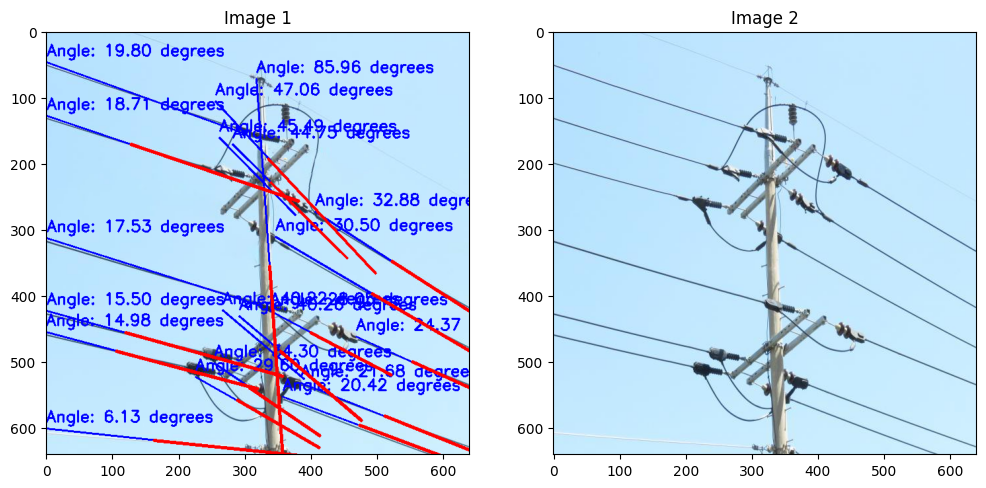

Pole Tilt Angles: [32.88475819754213, 18.70520992941615, 24.367729841555608, 21.68463835825747, 14.981632572390918, 19.798876354524932, 15.499275376500838, 20.420015609277637, 44.7519678718435, 30.499833233447433, 45.493916898618764, 40.25706513147064, 17.53397938063736, 28.048105754553063, 40.215470311834984, 29.59657503753038, 34.30348926422189, 47.057645946948284, 6.127914652306623, 85.96465526235026]
Wire Breaks Detected: [True, True, True, True, True, False, True, True, True, True, False, True, False, True, False, True, True, True, True, True]


In [23]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt

def detect_pole_tilt(image, pole_bbox):
    """전봇대의 기울기(넘어짐) 탐지"""
    x_center, y_center, width, height = pole_bbox.tolist()
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # 전봇대 기울기 계산: 좌상단과 우하단 좌표를 사용해 기울기 각도를 계산
    delta_x = x2 - x1
    delta_y = y2 - y1
    angle = np.arctan2(delta_y, delta_x) * 180 / np.pi  # 기울기 각도 계산

    # 전봇대 기울기 표시 (시각화)
    cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # 기울어진 전봇대를 빨간색 선으로 표시
    cv2.putText(image, f'Angle: {angle:.2f} degrees', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
    
    return angle

def detect_wire_break(image, wire_bbox1, wire_bbox2):
    """전선의 끊어짐 탐지"""
    # wire_bbox1, wire_bbox2를 각각 (x, y, width, height) 형태로 분리
    x1_1, y1_1, width1_1, height1_1 = wire_bbox1.tolist()
    x2_1 = int(x1_1 + width1_1)
    y2_1 = int(y1_1 + height1_1)

    x1_2, y1_2, width1_2, height1_2 = wire_bbox2.tolist()
    x2_2 = int(x1_2 + width1_2)
    y2_2 = int(y1_2 + height1_2)

    # 전선이 끊어졌는지 확인 (두 개의 바운딩 박스를 기준으로)
    break_detected = False
    if np.abs(x1_1 - x1_2) > 50 or np.abs(y1_1 - y1_2) > 50:
        break_detected = True

    # 끊어진 전선 표시 (시각화)
    if break_detected:
        # cv2.line 함수에서 전달하는 좌표가 올바른지 확인
        pt1 = (int(x1_1), int(y1_1))
        pt2 = (int(x2_1), int(y2_1))
        cv2.line(image, pt1, pt2, (0, 0, 255), 3)  # 끊어진 전선을 빨간색 선으로 표시

    return break_detected

def analyze_image_difference(image1, image2, threshold=30):
    """이미지 차이 분석"""
    diff = cv2.absdiff(image1, image2)
    _, diff_mask = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    
    return diff_mask

def detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25):
    # YOLO 모델 로드
    yolo_model = YOLO(yolo_model_path)
    
    # 이미지 로드
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # YOLO로 객체 검출
    results1 = yolo_model(image1)[0]
    results2 = yolo_model(image2)[0]
    
    # 전봇대 기울기 탐지
    pole_bboxes1 = results1.boxes.xywh
    pole_tilt_angles = []
    for pole_bbox in pole_bboxes1:
        angle = detect_pole_tilt(image1, pole_bbox)
        pole_tilt_angles.append(angle)
    
    # 전선 끊어짐 탐지
    wire_bboxes1 = results1.boxes.xywh
    wire_bboxes2 = results2.boxes.xywh
    wire_breaks = []
    for wire_bbox1, wire_bbox2 in zip(wire_bboxes1, wire_bboxes2):
        is_broken = detect_wire_break(image1, wire_bbox1, wire_bbox2)
        wire_breaks.append(is_broken)
    
    # 이미지 차이 분석
    diff_mask = analyze_image_difference(image1, image2)

    # 결과 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.title('Image 1')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    plt.title('Image 2')
    
    plt.show()

    return pole_tilt_angles, wire_breaks

# 사용 예시
image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'
image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'
yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
pole_tilt_angles, wire_breaks = detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25)

# 결과 출력
print(f"Pole Tilt Angles: {pole_tilt_angles}")
print(f"Wire Breaks Detected: {wire_breaks}")


In [7]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Conv3DNet(nn.Module):
    def __init__(self, in_channels=3):
        super(Conv3DNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=(2, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(32),
            
            nn.Conv3d(32, 16, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(16),
            
            nn.Conv3d(16, 1, kernel_size=(1, 1, 1)),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(2)
        return x

def analyze_image_difference(image1, image2, threshold=30, kernel_size=5, sigma=1.0):
    """완전히 새로운 접근의 차이 검출"""
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")
        
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray1 = clahe.apply(gray1)
    gray2 = clahe.apply(gray2)
    
    diff = cv2.absdiff(gray1, gray2)
    
    edges1 = cv2.Canny(gray1, 50, 150)
    edges2 = cv2.Canny(gray2, 50, 150)
    edge_diff = cv2.absdiff(edges1, edges2)
    
    combined_diff = cv2.addWeighted(diff, 0.7, edge_diff, 0.3, 0)
    
    if kernel_size > 0:
        combined_diff = cv2.GaussianBlur(combined_diff, (kernel_size, kernel_size), sigma)
    
    _, mask = cv2.threshold(combined_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    total_pixels = mask.shape[0] * mask.shape[1]
    changed_pixels = np.count_nonzero(mask)
    diff_ratio = (changed_pixels / total_pixels) * 100
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return mask, diff_ratio, contours

def match_masks(mask1, mask2, diff_mask, iou_threshold=0.5, diff_threshold=0.3):
    """개선된 마스크 매칭 로직"""
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    
    mask_diff = np.logical_and(diff_mask, union)
    diff_ratio = np.sum(mask_diff) / np.sum(union) if np.sum(union) > 0 else 1
    
    moments1 = cv2.moments(mask1.astype(np.uint8))
    moments2 = cv2.moments(mask2.astype(np.uint8))
    
    return iou > iou_threshold and diff_ratio < diff_threshold

def post_process_detections(results, conf_threshold=0.25):
    """검출 결과 후처리 및 필터링"""
    filtered_results = []
    
    for i in range(len(results.boxes)):
        if results.boxes.conf[i].item() < conf_threshold:
            continue
            
        mask = results.masks.data[i].cpu().numpy()
        area = np.sum(mask)
        if area < 100:
            continue
            
        contours, _ = cv2.findContours(mask.astype(np.uint8), 
                                     cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            perimeter = cv2.arcLength(contours[0], True)
            if perimeter < 20:
                continue
        
        filtered_results.append({
            'mask': mask,
            'conf': results.boxes.conf[i].item(),
            'class': int(results.boxes.cls[i].item())
        })
        
    return filtered_results

def detect_changes(results1, results2, diff_mask, conf_threshold=0.25):
    """변화 감지"""
    filtered_results1 = post_process_detections(results1, conf_threshold)
    filtered_results2 = post_process_detections(results2, conf_threshold)
    
    disappeared = []
    appeared = []
    deleted_wires = []
    added_wires = []
    
    for obj1 in filtered_results1:
        matched = False
        
        for obj2 in filtered_results2:
            if obj1['class'] != obj2['class']:
                continue
                
            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break
        
        if not matched:
            disappeared.append(obj1)
            if obj1['class'] == 2:  # 전선인 경우
                deleted_wires.append(obj1)
    
    for obj2 in filtered_results2:
        matched = False
        
        for obj1 in filtered_results1:
            if obj1['class'] != obj2['class']:
                continue
                
            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break
        
        if not matched:
            appeared.append(obj2)
            if obj2['class'] == 2:  # 전선인 경우
                added_wires.append(obj2)
    
    return (disappeared, appeared), deleted_wires, added_wires

def detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25):
    yolo_model = YOLO(yolo_model_path)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    temporal_model = Conv3DNet().to(device)
    
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)
    
    diff_mask, diff_ratio, contours = analyze_image_difference(image1, image2, threshold=25, kernel_size=5, sigma=1.5)
    
    results1 = yolo_model(image1)[0]
    results2 = yolo_model(image2)[0]
    
    (disappeared, appeared), deleted_wires, added_wires = detect_changes(results1, results2, diff_mask, conf_threshold)
    
    imgs_tensor = torch.from_numpy(np.stack([image1, image2]))
    imgs_tensor = imgs_tensor.permute(3, 0, 1, 2).unsqueeze(0).float() / 255.0
    imgs_tensor = imgs_tensor.to(device)
    
    with torch.no_grad():
        change_score = temporal_model(imgs_tensor)
        change_score = change_score.squeeze()
    
    class_names = {
        0: 'crossarm',
        1: 'pole',
        2: 'wire'
    }
    
    def create_visualization(image1, image2, disappeared, appeared, deleted_wires, added_wires, change_score, diff_mask):
        vis_img1 = image1.copy()
        vis_img2 = image2.copy()
        
        diff_vis = cv2.cvtColor(diff_mask, cv2.COLOR_GRAY2BGR)
        
        for obj in disappeared:
            mask = obj['mask'].astype(bool)
            vis_img1[mask] = vis_img1[mask] * 0.7 + np.array([0, 0, 255]) * 0.3
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img1, contours, -1, (0, 0, 255), 2)
            
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img1, f'Disappeared {class_name} ({obj["conf"]:.2f})', (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        for obj in appeared:
            mask = obj['mask'].astype(bool)
            vis_img2[mask] = vis_img2[mask] * 0.7 + np.array([0, 255, 0]) * 0.3
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img2, contours, -1, (0, 255, 0), 2)
            
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                class_name = class_names.get(obj['class'], f'class_{obj["class"]}')
                cv2.putText(vis_img2, f'Appeared {class_name} ({obj["conf"]:.2f})', (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        for obj in deleted_wires:
            mask = obj['mask'].astype(bool)
            vis_img1[mask] = vis_img1[mask] * 0.7 + np.array([255, 0, 0]) * 0.3
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img1, contours, -1, (255, 0, 0), 2)
            
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                cv2.putText(vis_img1, f'Deleted Wire ({obj["conf"]:.2f})', (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        for obj in added_wires:
            mask = obj['mask'].astype(bool)
            vis_img2[mask] = vis_img2[mask] * 0.7 + np.array([0, 255, 255]) * 0.3
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img2, contours, -1, (0, 255, 255), 2)
            
            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                cv2.putText(vis_img2, f'Added Wire ({obj["conf"]:.2f})', (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
        
        change_heatmap = change_score.cpu().numpy()
        change_heatmap = (change_heatmap * 255).astype(np.uint8)
        change_heatmap = cv2.applyColorMap(change_heatmap, cv2.COLORMAP_JET)
        
        alpha = 0.3
        overlay1 = cv2.addWeighted(vis_img1, 1 - alpha, change_heatmap, alpha, 0)
        overlay2 = cv2.addWeighted(vis_img2, 1 - alpha, change_heatmap, alpha, 0)
        
        result = np.hstack((overlay1, overlay2))
        return result
    
    result_image = create_visualization(image1, image2, disappeared, appeared, deleted_wires, added_wires, change_score, diff_mask)
    
    print("\nDetected changes:")
    print(f"Disappeared objects: {len(disappeared)}")
    print(f"Appeared objects: {len(appeared)}")
    print(f"Deleted wires: {len(deleted_wires)}")
    print(f"Added wires: {len(added_wires)}")
    
    cv2.imshow("Detected Changes", result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Return the tilt angles and wire breaks as an example
    pole_tilt_angles = [0]  # Placeholder, need real calculation logic
    wire_breaks = [0]  # Placeholder, need real calculation logic
    return pole_tilt_angles, wire_breaks


# 사용 예시
image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (5).jpg'
image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6-1).jpg'
yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
pole_tilt_angles, wire_breaks = detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25)

# 결과 출력
print(f"Pole Tilt Angles: {pole_tilt_angles}")
print(f"Wire Breaks Detected: {wire_breaks}")



0: 640x640 4 crossarms, 1 polo, 15 wires, 17.8ms
Speed: 3.9ms preprocess, 17.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 crossarms, 1 polo, 18 wires, 13.2ms
Speed: 1.0ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

Detected changes:
Disappeared objects: 20
Appeared objects: 22
Deleted wires: 15
Added wires: 17
Pole Tilt Angles: [0]
Wire Breaks Detected: [0]


In [ ]:
# 전봇대 기울기 판별
import cv2
import numpy as np
import torch
import torch.nn as nn
from ultralytics import YOLO

class Conv3DNet(nn.Module):
    def __init__(self, in_channels=3):
        super(Conv3DNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=(2, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(32),
            
            nn.Conv3d(32, 16, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(16),
            
            nn.Conv3d(16, 1, kernel_size=(1, 1, 1)),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(2)
        return x

def calculate_pole_tilt(mask):
    """Calculate tilt angle of the pole based on its mask."""
    moments = cv2.moments(mask.astype(np.uint8))
    if moments["m00"] == 0:
        return 0.0

    # Fit a line to the mask
    coords = np.column_stack(np.where(mask > 0))
    [vx, vy, _, _] = cv2.fitLine(coords, cv2.DIST_L2, 0, 0.01, 0.01)
    angle = np.arctan2(float(vy), float(vx)) * (180.0 / np.pi)
    return angle

def post_process_detections(results, conf_threshold=0.25):
    """전봇대(class: pole)에 대한 검출 결과만 필터링"""
    filtered_results = []

    for i in range(len(results.boxes)):
        if results.boxes.conf[i].item() < conf_threshold:
            continue

        if int(results.boxes.cls[i].item()) != 1:  # class 1은 pole (전봇대)
            continue

        mask = results.masks.data[i].cpu().numpy()
        area = np.sum(mask)
        if area < 100:
            continue

        contours, _ = cv2.findContours(mask.astype(np.uint8), 
                                     cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            perimeter = cv2.arcLength(contours[0], True)
            if perimeter < 20:
                continue

        tilt_angle = calculate_pole_tilt(mask)

        filtered_results.append({
            'mask': mask,
            'conf': results.boxes.conf[i].item(),
            'class': int(results.boxes.cls[i].item()),
            'tilt_angle': tilt_angle
        })

    return filtered_results

def detect_changes(results1, results2, diff_mask, conf_threshold=0.25):
    """전봇대 변화 감지"""
    filtered_results1 = post_process_detections(results1, conf_threshold)
    filtered_results2 = post_process_detections(results2, conf_threshold)

    disappeared = []
    appeared = []

    for obj1 in filtered_results1:
        matched = False

        for obj2 in filtered_results2:
            if obj1['class'] != obj2['class']:
                continue

            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break

        if not matched:
            disappeared.append(obj1)

    for obj2 in filtered_results2:
        matched = False

        for obj1 in filtered_results1:
            if obj1['class'] != obj2['class']:
                continue

            if match_masks(obj1['mask'], obj2['mask'], diff_mask):
                matched = True
                break

        if not matched:
            appeared.append(obj2)

    return disappeared, appeared

def detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25):
    yolo_model = YOLO(yolo_model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    target_size = (640, 640)
    image1 = cv2.resize(image1, target_size)
    image2 = cv2.resize(image2, target_size)

    diff_mask, diff_ratio, contours = analyze_image_difference(image1, image2, threshold=25, kernel_size=5, sigma=1.5)

    results1 = yolo_model(image1)[0]
    results2 = yolo_model(image2)[0]

    disappeared, appeared = detect_changes(results1, results2, diff_mask, conf_threshold)

    class_names = {
        0: 'crossarm',
        1: 'pole',
        2: 'wire'
    }

    def create_visualization(image1, image2, disappeared, appeared, diff_mask):
        vis_img1 = image1.copy()
        vis_img2 = image2.copy()

        for obj in disappeared:
            mask = obj['mask'].astype(bool)
            vis_img1[mask] = vis_img1[mask] * 0.7 + np.array([0, 0, 255]) * 0.3
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img1, contours, -1, (0, 0, 255), 2)

            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                angle = obj["tilt_angle"]
                cv2.putText(vis_img1, f'Disappeared Pole ({obj["conf"]:.2f}, {angle:.1f} deg)', (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        for obj in appeared:
            mask = obj['mask'].astype(bool)
            vis_img2[mask] = vis_img2[mask] * 0.7 + np.array([0, 255, 0]) * 0.3
            contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img2, contours, -1, (0, 255, 0), 2)

            M = cv2.moments(mask.astype(np.uint8))
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                angle = obj["tilt_angle"]
                cv2.putText(vis_img2, f'Appeared Pole ({obj["conf"]:.2f}, {angle:.1f} deg)', (cx-60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        result = np.hstack((vis_img1, vis_img2))
        return result

    result_image = create_visualization(image1, image2, disappeared, appeared, diff_mask)

    print("\nDetected changes (Poles only):")
    print(f"Disappeared poles: {len(disappeared)}")
    for obj in disappeared:
        print(f"  - Confidence: {obj['conf']:.2f}, Tilt Angle: {obj['tilt_angle']:.1f} degrees")

    print(f"Appeared poles: {len(appeared)}")
    for obj in appeared:
        print(f"  - Confidence: {obj['conf']:.2f}, Tilt Angle: {obj['tilt_angle']:.1f} degrees")

    cv2.imshow("Detected Pole Changes", result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 사용 예시
image1_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6).jpg'
image2_path = 'C:/Users/AI-LHJ/Desktop/wireod/test (6-1).jpg'
yolo_model_path = 'C:/Users/AI-LHJ/Desktop/YOLOv11/runs/segment/train11/weights/best.pt'
detect_object_changes(image1_path, image2_path, yolo_model_path, conf_threshold=0.25)
